<a href="https://colab.research.google.com/github/tarunbjoseph/MIE1517-A1/blob/main/A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: PyTorch Basics

## Overview

In this assignment, you will:
1. Build a simple neural network from scratch to understand how neural networks work.
2. Train a neural network (using PyTorch) to classify images from the Garbage Classification dataset into one of 7 classes (battery, biological, cardboard, etc.).

The provided code will guide you through key steps, but by the end of the assignment, you should:

1. Understand the training loop for a machine learning model.
2. Distinguish between training, validation, and test data.
3. Learn about overfitting and underfitting.
4. Explore how hyperparameters, like learning rate and batch size, impact training.
5. Compare a basic feedforward neural network (ANN) with a convolutional neural network (CNN).

This assignment is inspired by materials developed by Prof. Lisa Zhang.


## What to Submit

1. Submit the `.ipynb` and `.html` files containing your code, outputs, and answers from all parts. Please take extra effort to make your answers and submissions readable. Do not display unnecessary outputs, only the ones that are important for supporting your answers.

  You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.


2. Submit your model predictions on the secret test dataset for Parts B-5 and B-6  as `labels_part_b5.csv` and `labels_part_b6.csv`.

**Important**: Do not submit additional files generated by your code.

Please use Google Colab for this assignment. If you prefer Jupyter Notebook, ensure the file is uploaded to Colab for submission.


## Colab Link

Include a link to your colab file here and ensure the file can be accessed by the our teaching team.

Colab Link:

In [1]:
# TO BE COMPLETED

# https://github.com/tarunbjoseph/MIE1517-A1/blob/main/A1.ipynb

# https://colab.research.google.com/drive/1Hohs42rL1TpyXQ-XAywy7tr6TwcRgJcE?usp=sharing

# PART A: Building a Neural Network from Scratch [8pt]

Before we get into using PyTorch to train our classifier we will go through the process of creating our neural network from scratch. We've seen in the tutorial how to build a 1-layer network, now we'll take it one step further to build a 2-layer network. This is an important exercise that everyone should attempt at least once to understand and truly appreciate the workings of neural networks.

## Helper Functions

To help guide the construction we will use the sklearn wine dataset. Provided are some helper code to get us started:


In [2]:
import pandas as pd
from sklearn.datasets import load_wine
import numpy as np

d = load_wine()
raw_data = np.c_[d.data, d.target]
raw_data = raw_data[~np.isnan(raw_data).any(axis=1)].astype(float)

np.random.shuffle(raw_data)

In [3]:
import numpy as np

# split your data into training and validation
X_train = raw_data[0:100,:13]
y_train = raw_data[0:100,13:14].astype(int)
X_val = raw_data[100:,:13]
y_val = raw_data[100:,13:14].astype(int)

print(X_train.shape, y_train.shape)
print(X_train.dtype, y_train.dtype)
print(X_val.shape, y_val.shape)
print(X_val.dtype, y_val.dtype)

(100, 13) (100, 1)
float64 int64
(78, 13) (78, 1)
float64 int64


Recall that the neural network output consists of several nodes, one for each output class. Since the labels are provided as integers we will need to convert them into one-hot vectors to match the neural network output format.

In [4]:
#Convert array to one-hot encoding
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

In [5]:
y_train = to_one_hot(y_train)
print(X_train.shape, y_train.shape)
print(X_train.dtype, y_train.dtype)

y_val = to_one_hot(y_val)
print(X_val.shape, y_val.shape)
print(X_val.dtype, y_val.dtype)

(100, 13) (100, 3)
float64 float64
(78, 13) (78, 3)
float64 float64


In [6]:
# Normalizing the X_train and X_val data
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

In [7]:
#verify one-hot encoding
y_train[0:5,:]

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

## Part A-1. Develop a 2-layer ANN [6pt MODEL]
At its core a 2-layer neural network is just a few lines of code. Most of the complexity comes from setting up the training of the network.

Using vectorized form, set up the neural network training to use a cross-entropy loss function and determine the gradients with resepect to the layer 1 and layer 2 weights.

In [8]:
# write code to create a 2-layer ANN in vectorized form

#define sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-x))

#define softmax
def softmax(x):
  e = np.exp(x)
  return e/e.sum(axis=1, keepdims = True)


def ann(W, X_train, y_train):

  num_hidden = 20
  num_features = 13
  num_outputs = 3

  #Weights
  w0 = W[:num_features*num_hidden].reshape(num_features, num_hidden)
  w1 = W[num_features*num_hidden:].reshape(num_hidden, num_outputs)

  #Feed forward
  layer0 = X_train
  layer1 = sigmoid(np.dot(layer0, w0))
  layer2 = np.dot(layer1, w1)

  # softmax
  y_pred = softmax(layer2)

  #Back propagation using gradient descent

  #cross-entropy loss
  error = -np.sum(y_train * np.log(y_pred)) / y_train.shape[0]

  #initialize gradients to zero
  dw0 = np.zeros_like(w0)
  dw1 = np.zeros_like(w1)

  #calculate gradients
  # For the output layer, I'm dividing by the batch size in order to average the gradients across the batch for stable weight updates
  delta2 = (y_pred - y_train) / y_train.shape[0]
  delta1 = np.dot(delta2, w1.T) * layer1 * (1 - layer1)
  # dw1 += np.dot(layer1.T, delta2)
  # dw0 += np.dot(layer0.T, delta1)

  #determine gradients
  dw1 += np.dot(layer1.T, delta2)
  dw0 += np.dot(layer0.T, delta1)

  #combine gradients into one vector
  dW = np.concatenate([dw0.flatten(), dw1.flatten()])

  return (error, dW, y_pred)


## Part A-2. Train your neural network [1pt RESULT]
Train your neural network once with random initialization (uniformly at random between -1 and +1), and once with zero initialization (all weights = 0).

Compare results. Comment on how well does your network work on the wine dataset in these two cases and why?

In [9]:
num_hidden = 20
num_features = 13
num_outputs = 3


def train_and_evaluate(w0_init, w1_init, label=""):

    #initial weights: w0_init, w1_init

    #combine weights into a single vector
    W = np.array(list(w0_init.flatten()) + list(w1_init.flatten()))

    #train network
    n = 0.001
    iterations = 100000
    errors = []
    for i in range(iterations):
        (error, dW, y_pred) = ann(W, X_train, y_train)
        W += -dW * n
        errors.append(error)

    # final predictions
    _, _, y_pred = ann(W, X_train, y_train)
    y_pred_labels = np.round(y_pred, 0)
    y_true_labels = np.round(y_train, 0)

    print(f"{label} initialization: Predictions on training data: \n{y_pred_labels[:5]}")
    print(f"{label} initialization: Ground truth training data: \n{y_true_labels[:5]}")

    accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1))
    print(f"{label} initialization: Final training accuracy: {accuracy:.4f}")

    return errors, accuracy

In [10]:
# Scaled random initialization
w0_rand = np.random.randn(num_features, num_hidden) * 0.01
w1_rand = np.random.randn(num_hidden, num_outputs) * 0.01
errors_rand, accuracy_rand = train_and_evaluate(w0_rand, w1_rand, "Random")

Random initialization: Predictions on training data: 
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Random initialization: Ground truth training data: 
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Random initialization: Final training accuracy: 1.0000


In [11]:
# Uniform random initialization between -1 and +1
w0_uniform = np.random.uniform(-1, 1, size=(num_features, num_hidden))
w1_uniform = np.random.uniform(-1, 1, size=(num_hidden, num_outputs))
errors_uniform, accuracy_uniform = train_and_evaluate(w0_uniform, w1_uniform, "Uniform")

Uniform initialization: Predictions on training data: 
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Uniform initialization: Ground truth training data: 
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Uniform initialization: Final training accuracy: 1.0000


In [12]:
#zero initialization
w0_zero = np.zeros((num_features, num_hidden))
w1_zero = np.zeros((num_hidden, num_outputs))
errors_zero, acc_zero = train_and_evaluate(w0_zero, w1_zero, "Zero")

Zero initialization: Predictions on training data: 
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Zero initialization: Ground truth training data: 
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Zero initialization: Final training accuracy: 0.4300


In [13]:
'''
PROVIDE YOUR ANSWER BELOW

Based on the three initialization results obtained above, I can see that:
- Before normalizing the X_train and X_val data:

  - Scaled Random Initialization has the highest accuracy (0.95).This method is generally effective as it breaks symmetry between neurons, allowing them to learn distinct features. The small values prevent activation functions
  (sigmoid and softmax) from saturating too early, thus avoiding vanishing/exploding gradient issues and ensuring a good fit.

  - Uniform Random Initialization between -1 and +1 resulted in an accuracy of 0.42. The large intial weights caused the sigmoid activation function to output values very close to 0 or 1, leading to saturation which resulted in
  vanishing gradients, making it difficult for the network to learn effectively.

  - Zero Initialization resulted in the lowest accuracy of 0.37. Initializing all weights to zero leads to a symmetry problem. All neurons in a layer will learn the exact same features during backpropagation, effectively making the
  network no more powerful than a single neuron.

- After normalizing the X_train and X_val data, I observed that the accuracy of training accuracy for both the scaled and uniform random initialization comes to 1.00.

- In summary, I observed that proper random initialization is crucial in order for the network to learn effectively without issues like vanishing gradients or symmetry problems.

'''

'\nPROVIDE YOUR ANSWER BELOW\n\nBased on the three initialization results obtained above, I can see that:\n- Before normalizing the X_train and X_val data:\n\n  - Scaled Random Initialization has the highest accuracy (0.95).This method is generally effective as it breaks symmetry between neurons, allowing them to learn distinct features. The small values prevent activation functions\n  (sigmoid and softmax) from saturating too early, thus avoiding vanishing/exploding gradient issues and ensuring a good fit.\n\n  - Uniform Random Initialization between -1 and +1 resulted in an accuracy of 0.42. The large intial weights caused the sigmoid activation function to output values very close to 0 or 1, leading to saturation which resulted in\n  vanishing gradients, making it difficult for the network to learn effectively.\n\n  - Zero Initialization resulted in the lowest accuracy of 0.37. Initializing all weights to zero leads to a symmetry problem. All neurons in a layer will learn the exact 

## Part A-3. Validation [2pt MODEL]
Validate that the gradients were computed correctly for the 2-layer neural network you developed.

In [14]:
num_hidden = 20
num_features = 13
num_outputs = 3

#initialize weights uniformly at random between -1 and +1, and combine weights
w0 = np.random.uniform(-1, 1, size=(num_features, num_hidden))
w1 = np.random.uniform(-1, 1, size=(num_hidden, num_outputs))
W = np.array(list(w0.flatten()) + list(w1.flatten()))

#compute gradients analytically
(error, dW, y_pred) = ann(W, X_train, y_train)

#compute gradients numerically
dW_num = np.zeros((len(W),1))

epsilon = 1e-4 # Define a small epsilon for numerical approximation

for ind in range(len(W)):
  #reset gradients
  We1 = np.array(list(w0.flatten()) + list(w1.flatten()))
  We2 = np.array(list(w0.flatten()) + list(w1.flatten()))

  #increment slightly
  We1[ind] = W[ind] - epsilon
  We2[ind] = W[ind] + epsilon

  #compute errors
  (error_e1, dW_e1, y_pred1) = ann(We1, X_train, y_train)
  (error_e2, dW_e2, y_pred2) = ann(We2, X_train, y_train)

  #obtain numerical gradients
  grad_num = (error_e2 - error_e1) / (We2[ind] - We1[ind])

  #display difference between numerical and analytic gradients
  print(round(abs(grad_num - dW[ind]), 4), grad_num, dW[ind])

0.0 0.040286149811668 0.04028614976684946
0.0 0.06373265747706283 0.06373265747378953
0.0 -0.03916921335167954 -0.03916921334436358
0.0 0.040961601406318486 0.040961601419380766
0.0 -0.13829197019088071 -0.13829197027884857
0.0 -0.006674559906994684 -0.0066745599192304704
0.0 0.005887214318267385 0.005887214318962812
0.0 -0.01488133121952004 -0.014881331217749257
0.0 0.06052159345460551 0.06052159348279973
0.0 -0.019282814420762524 -0.019282814436471344
0.0 -0.1181749349199587 -0.11817493499535028
0.0 0.012740440266113833 0.012740440271470442
0.0 -0.10303419987200672 -0.10303419991697835
0.0 -0.025092707454102404 -0.02509270747081583
0.0 0.17341126105298832 0.17341126116574576
0.0 0.07298415313106958 0.0729841531888275
0.0 -0.1400784871585946 -0.14007848725876337
0.0 -0.15242370319358836 -0.15242370332879893
0.0 0.10013617388838762 0.10013617390264339
0.0 -0.04107705760536992 -0.041077057639695116
0.0 0.028820978642544025 0.028820978684210987
0.0 0.0024516984720171424 0.002451698478953

**Answer:**

- The gradient validation appears successful as for most weights the difference between the numerical and analytical gradients is 0.0 which ensures that the `ann` function is correctly calculating the gradients.

# PART B: Training with PyTorch

In the second part of the assignment we will see how we can use PyTorch to train a neural network to classify different garbage items.


In [9]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import shutil

## Part B-0. Helper Functions

We will be making use of the following helper functions. If you are using Google Colab, you may change runtime type to GPU to speed up the training process in this part. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [10]:
###############################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data Loading

def get_data_loader(data_dir, batch_size, valid_split=0.2):
    """
    Load the Garbage Classification Dataset, split into training, validation, and testing.

    Args:
        data_dir: The root directory of the dataset, with subdirectories for each class.
        batch_size: Number of samples per batch.
        valid_split: Fraction of the training data to be used for validation.

    Returns:
        train_loader: Iterable DataLoader for training data.
        val_loader: Iterable DataLoader for validation data.
        test_loader: Iterable DataLoader for testing data.
        classes: List of class names.
    """
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize to 128x128
        transforms.ToTensor(),         # Convert to Tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])

    # Load the full dataset
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    classes = dataset.classes  # Get class names

    # Split the dataset
    total_size = len(dataset)
    test_size = int(0.1 * total_size)  # 10% for testing
    valid_size = int(valid_split * (total_size - test_size))  # Valid from remaining
    train_size = total_size - test_size - valid_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Normalize labels for multi-class classification.

    Args:
        labels: A 1D tensor of scalar class labels.
    Returns:
        The same labels (already suitable for multi-class classification).
    """
    return labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on a given dataset.

     Args:
         net: PyTorch neural network object.
         loader: PyTorch DataLoader for valuation data.
         criterion: The loss function.

     Returns:
         err: Average classification error rate over the validation set.
         loss: Average loss value over the validation set.
    """
    total_loss = 0.0
    total_err = 0.0
    total_samples = 0
    net = net.to(device)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Compute classification error
            _, predicted = torch.max(outputs, 1)
            total_err += (predicted != labels).sum().item()
            total_loss += loss.item()
            total_samples += len(labels)

    err = total_err / total_samples
    avg_loss = total_loss / len(loader)
    return err, avg_loss

###############################################################################
# Training Curve

def plot_training_curve(path, return_val_error=False):
    """ Plot training and validation error/loss curves.

    Args:
        path: Base path for the CSV files containing training logs.
        return_val_error: If True, return the final validation error.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    train_err = np.loadtxt(f"{path}_train_err.csv")
    val_err = np.loadtxt(f"{path}_val_err.csv")
    train_loss = np.loadtxt(f"{path}_train_loss.csv")
    val_loss = np.loadtxt(f"{path}_val_loss.csv")

    if return_val_error:
        return val_err[-1]  # Return the final validation error

    plt.figure()
    plt.title("Train vs Validation Error")
    plt.plot(range(1, len(train_err) + 1), train_err, label="Train")
    plt.plot(range(1, len(val_err) + 1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

    plt.figure()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train")
    plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

Using device: cuda


## Part B-1. Visualizing the Data

We will make use of the truncated version of garbage classification dataset, which consists of
color images of various garbage items such as batteries, biological items,
cardboards, and more. These images are resized to 128x128 pixels.
You can find the full dataset at https://www.kaggle.com/datasets/sudipp/garbage-dataset-9-classes

Download the "garbage_dataset.zip" file from Quercus and upload it to your colab session storage.
Run the provided code to automatically unzip the dataset  and split the dataset into
training, validation, and testing sets.

In [21]:
_ = !unzip "/content/garbage_dataset.zip" -d "/content/garbage_dataset/"

In [22]:
# Load the Garbage Classification Dataset
data_dir = "./garbage_dataset/garbage_dataset"  # Path to the dataset directory
batch_size = 1  # One image per batch for visualization

# Use the get_data_loader function to load the dataset
train_loader, val_loader, test_loader, classes = get_data_loader(
    data_dir=data_dir, batch_size=batch_size
)

In [23]:
classes

['battery', 'biological', 'cardboard', 'glass', 'metal', 'paper', 'plastic']

### Part B-1(i) [0.5pt EXPLORATORY]

Below is some sample plotting code that visualizes a small batch of images from your training set. Currently, it plots 15 images in a 3 × 5 grid.


Modify the code so that it instead plots 30 images in a 3 × 10 grid, and displays the ground-truth label above each subplot.
You may use the provided code as a starting point.

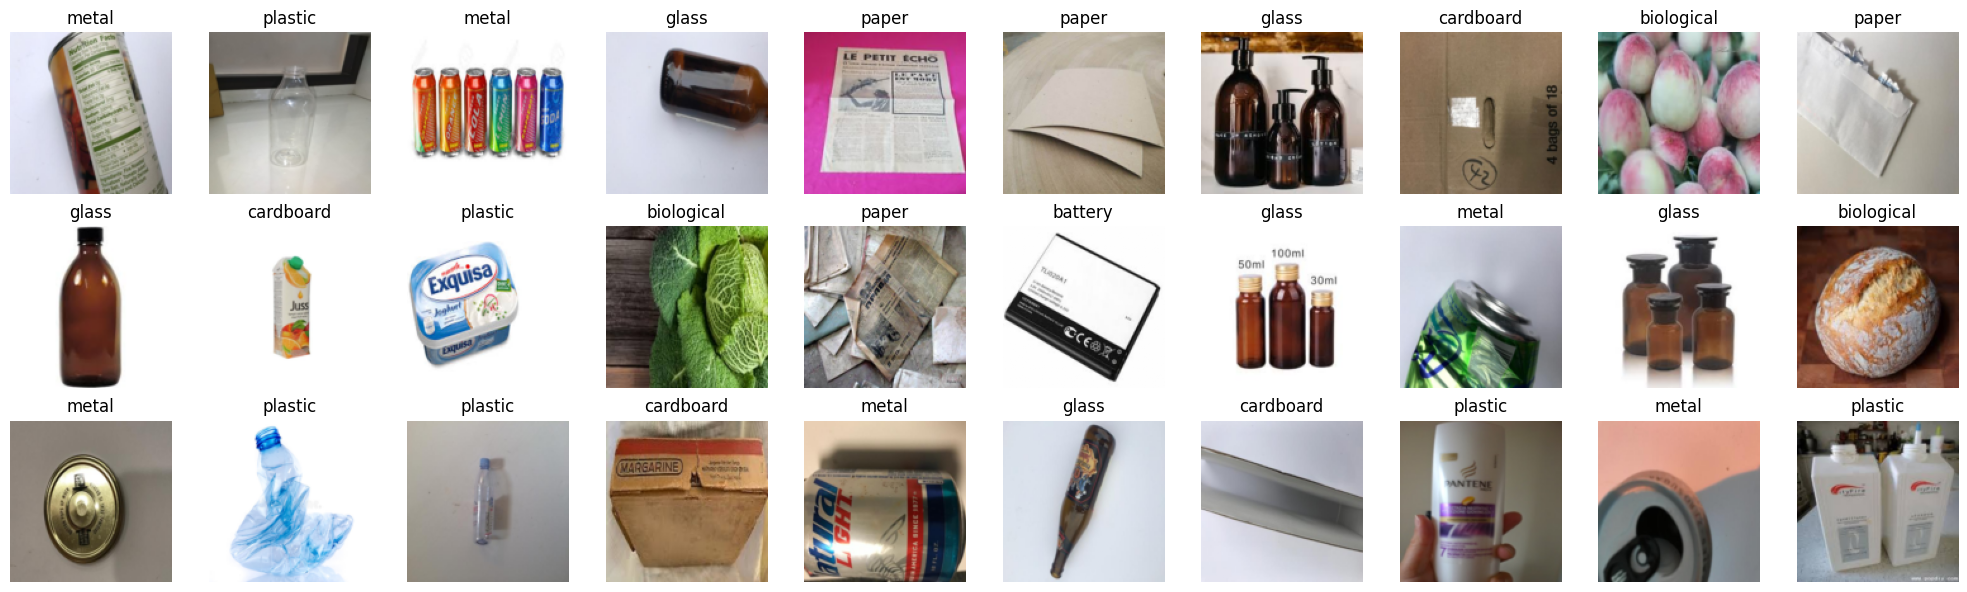

In [24]:
import matplotlib.pyplot as plt

k = 0
plt.figure(figsize=(20, 6))
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1, 2, 0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5  # normalize to [0, 1]
    plt.subplot(3, 10, k + 1)
    plt.axis('off')
    plt.imshow(img)
    # add title with class name
    plt.title(classes[labels[0].item()])
    # increment counter
    k += 1
    if k >= 30:
        break
plt.tight_layout()
plt.show()

### Part B-1(ii) [1pt EXPLORATORY]

How many training examples do we have for the combined classes?
What about validation examples?
What about test examples?

Plot the distribution of class labels in training/validation/test. Comment on whether the dataset is balanced or imbalanced.

In [25]:
# TO BE COMPLETED

# Calculate the number of examples in each split
num_train = len(train_loader.dataset)
num_val = len(val_loader.dataset)
num_test = len(test_loader.dataset)

print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")
print(f"Number of test examples: {num_test}")
print(f"Total examples: {num_train + num_val + num_test}")



Number of training examples: 1512
Number of validation examples: 378
Number of test examples: 210
Total examples: 2100


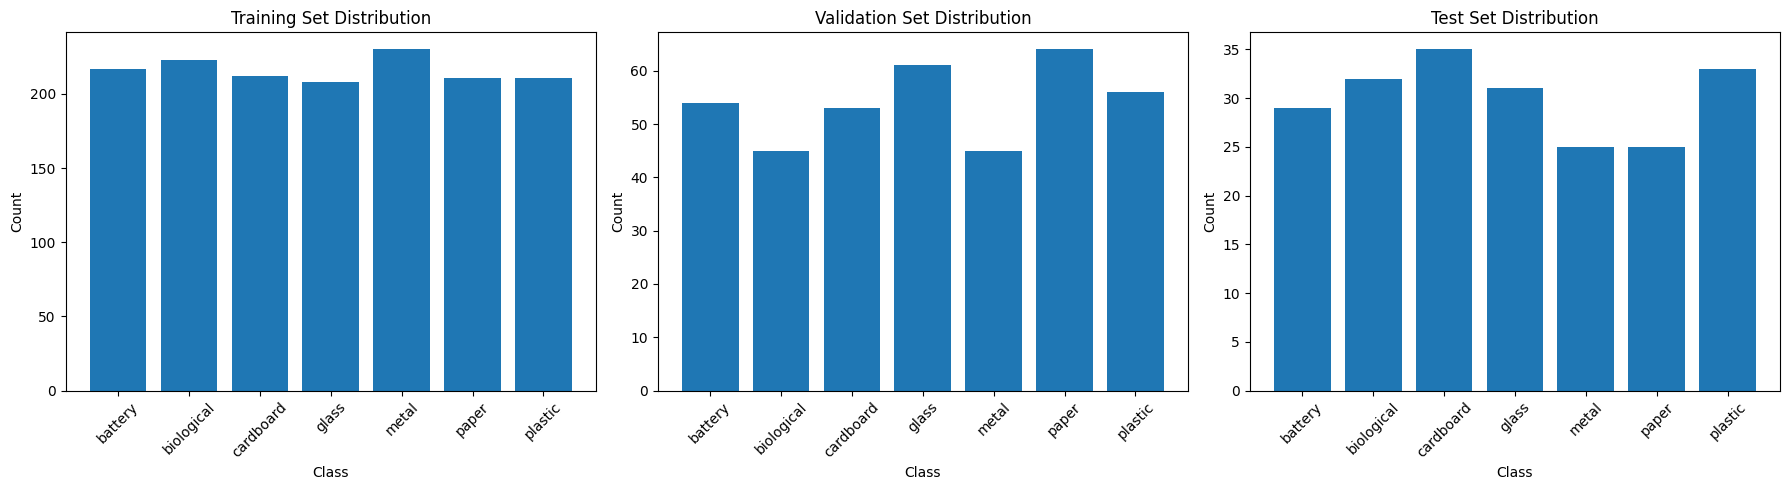

In [26]:
# Plot the distribution of class labels in training/validation/test
import matplotlib.pyplot as plt

# Get labels for each split
train_labels = [label for _, label in train_loader.dataset]
val_labels = [label for _, label in val_loader.dataset]
test_labels = [label for _, label in test_loader.dataset]

# Count occurrences of each class
train_counts = [train_labels.count(i) for i in range(len(classes))]
val_counts = [val_labels.count(i) for i in range(len(classes))]
test_counts = [test_labels.count(i) for i in range(len(classes))]

# Create bar plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(classes, train_counts)
axes[0].set_title('Training Set Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(classes, val_counts)
axes[1].set_title('Validation Set Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

axes[2].bar(classes, test_counts)
axes[2].set_title('Test Set Distribution')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [27]:
# Print detailed statistics
print("\nClass distribution:")
for i, class_name in enumerate(classes):
    print(f"{class_name}: Train={train_counts[i]}, Val={val_counts[i]}, Test={test_counts[i]}")


Class distribution:
battery: Train=217, Val=54, Test=29
biological: Train=223, Val=45, Test=32
cardboard: Train=212, Val=53, Test=35
glass: Train=208, Val=61, Test=31
metal: Train=230, Val=45, Test=25
paper: Train=211, Val=64, Test=25
plastic: Train=211, Val=56, Test=33


In [28]:
'''
PROVIDE YOUR ANSWER BELOW

- The total number of training examples across the 7 classes: 1512
- Total number of validation examples: 378
- Total number of test examples: 210
- Total examples: 2100

- Based on the class distribution plots and statistics, it is evident that the dataset is appropriately balanced across the different classes. The rule of thumb for a balanced dataset is that no single class should dominate the
dataset significantly. In this case, each class has a similar number of examples in the training, validation, and test sets. This balance is crucial for training robust machine learning models, as it helps prevent bias towards any
particular class and ensures that the model learns to generalize well across all classes.


'''

'\nPROVIDE YOUR ANSWER BELOW\n\n- The total number of training examples across the 7 classes: 1512\n- Total number of validation examples: 378\n- Total number of test examples: 210\n- Total examples: 2100\n\n- Based on the class distribution plots and statistics, it is evident that the dataset is appropriately balanced across the different classes. The rule of thumb for a balanced dataset is that no single class should dominate the\ndataset significantly. In this case, each class has a similar number of examples in the training, validation, and test sets. This balance is crucial for training robust machine learning models, as it helps prevent bias towards any\nparticular class and ensures that the model learns to generalize well across all classes.\n\n\n'

## Part B-2. Training

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [29]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 29 * 29, 32)
        self.fc2 = nn.Linear(32, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [30]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 31 * 31, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 31 * 31)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [31]:
small_net = SmallNet()
large_net = LargeNet()

### Part B-2(i) [1pt EXPLORATORY]

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [32]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([7, 4805])
torch.Size([7])


In [33]:
# TO BE COMPLETED

# Print the shape of each parameter tensor in LargeNet
for param in large_net.parameters():
    print(param.shape)





torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 8410])
torch.Size([32])
torch.Size([7, 32])
torch.Size([7])


In [34]:
# Total parameters in LargeNet and SmallNet (Multiplying the dimensions and summing them up across all layers)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
large_params = count_parameters(large_net)
small_params = count_parameters(small_net)
print(f"Total parameters in LargeNet: {large_params}")
print(f"Total parameters in SmallNet: {small_params}")


Total parameters in LargeNet: 271023
Total parameters in SmallNet: 33782


In [35]:
'''
PROVIDE YOUR ANSWER BELOW

After multiplying the dimensions and summing them up across all layers:

- The total number of parameters in LargeNet is 271,023.
- The total number of parameters in SmallNet is 33,782.



'''

'\nPROVIDE YOUR ANSWER BELOW\n\nAfter multiplying the dimensions and summing them up across all layers:\n\n- The total number of parameters in LargeNet is 271,023.\n- The total number of parameters in SmallNet is 33,782.\n\n\n\n'

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [36]:
# Directory in Drive to save everything
save_dir = "/content/drive/MyDrive/garbage_model_runs"
os.makedirs(save_dir, exist_ok=True)

In [37]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30, save_dir=save_dir):
    # Moving model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    net = net.to(device)
    ########################################################################
    # Train a classifier on an 7-class classification problem
    target_classes = ["battery", "biological", "cardboard", "glass",
                      "metal", "paper", "plastic"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible results
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            data_dir='/content/garbage_dataset/garbage_dataset',  # Ensure this is where your dataset is stored
            batch_size=batch_size)

    # Make sure the classes are as expected
    assert len(classes) == 7, "The dataset should have exactly 7 classes."
    ########################################################################
    # Define the Loss function and optimizer
    # Use CrossEntropyLoss for multi-class classification
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/accuracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # Loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)  # No need to normalize labels here for CrossEntropyLoss
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
            total_train_err += (predicted != labels).sum().item()  # Count errors
            total_train_loss += loss.item()
            total_epoch += len(labels)

        # Calculate error and loss for the training and validation set
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)

        # Print stats for the current epoch
        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | "
              f"Validation err: {val_err[epoch]:.4f}, Validation loss: {val_loss[epoch]:.4f}")

        # Save the current model (checkpoint) to a file
        model_path = os.path.join(
            save_dir,
            get_model_name(net.name, batch_size, learning_rate, epoch)
        )
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    # Write the train/test loss/error into CSV files for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt(f"{model_path}_train_err.csv", train_err)
    np.savetxt(f"{model_path}_train_loss.csv", train_loss)
    np.savetxt(f"{model_path}_val_err.csv", val_err)
    np.savetxt(f"{model_path}_val_loss.csv", val_loss)


### Part B-2(ii) [0.5pt EXPLORATORY]

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [38]:
'''
PROVIDE YOUR ANSWER BELOW

Based on the train_net function provided, the default values of the hyperparameters are:
- batch_size = 64
- learning_rate = 0.01
- num_epochs = 30




'''

'\nPROVIDE YOUR ANSWER BELOW\n\nBased on the train_net function provided, the default values of the hyperparameters are:\n- batch_size = 64\n- learning_rate = 0.01\n- num_epochs = 30\n\n\n\n\n'

### Part B-2(iii) [0.5pt EXPLORATORY]
What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [39]:
# Calling train_net to train SmallNet
train_net(small_net, num_epochs = 5)

Using device: cuda
Epoch 1: Train err: 0.7255, Train loss: 1.7770 | Validation err: 0.5873, Validation loss: 1.5302
Epoch 2: Train err: 0.5642, Train loss: 1.4802 | Validation err: 0.5926, Validation loss: 1.6709
Epoch 3: Train err: 0.5000, Train loss: 1.3807 | Validation err: 0.5741, Validation loss: 1.4315
Epoch 4: Train err: 0.4398, Train loss: 1.2049 | Validation err: 0.5423, Validation loss: 1.4373
Epoch 5: Train err: 0.3823, Train loss: 1.0818 | Validation err: 0.5344, Validation loss: 1.4947
Finished Training
Total time elapsed: 40.24 seconds


In [40]:
'''
PROVIDE YOUR ANSWER BELOW

After running train_net(small_net, num_epochs=5), the following files are created under "./garbage_model_runs" directory:

- 'model_small_bs64_lr0.01_epoch0' .... 'model_small_bs64_lr0.01_epoch4': model checkpoints for each epoch (PyTorch state_dict values of model weights) saved after each epoch.
- 'model_small_bs64_lr0.01_epoch4_train_err.csv': per‑epoch training error (5 values, one for each epoch)
- 'model_small_bs64_lr0.01_epoch4_val_err.csv': per‑epoch validation error (5 values, one for each epoch)
- 'model_small_bs64_lr0.01_epoch4_train_loss.csv': per‑epoch training loss (5 values, one for each epoch)
- 'model_small_bs64_lr0.01_epoch4_val_loss.csv': per‑epoch validation loss (5 values, one for each epoch)




'''

'\nPROVIDE YOUR ANSWER BELOW\n\nAfter running train_net(small_net, num_epochs=5), the following files are created under "./garbage_model_runs" directory:\n\n- \'model_small_bs64_lr0.01_epoch0\' .... \'model_small_bs64_lr0.01_epoch4\': model checkpoints for each epoch (PyTorch state_dict values of model weights) saved after each epoch.\n- \'model_small_bs64_lr0.01_epoch4_train_err.csv\': per‑epoch training error (5 values, one for each epoch)\n- \'model_small_bs64_lr0.01_epoch4_val_err.csv\': per‑epoch validation error (5 values, one for each epoch)\n- \'model_small_bs64_lr0.01_epoch4_train_loss.csv\': per‑epoch training loss (5 values, one for each epoch)\n- \'model_small_bs64_lr0.01_epoch4_val_loss.csv\': per‑epoch validation loss (5 values, one for each epoch)\n\n\n\n\n'

### Part B-2(iv) [0.5pt EXPLORATORY]
Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in the parts that follow.
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive to save model runs later. If you are working on the assignment locally, you
# can comment out this code.

from google.colab import drive
!ls /content/drive/MyDrive
!rm -rf /content/MyDrive
drive.mount('/content/drive')

In [42]:
# TO BE COMPLETED

# Training both SmallNet and LargeNet using train_net function with specified hyperparameters
# Re-construct SmallNet to reset weights
small_net = SmallNet()

train_net(small_net)







Using device: cuda
Epoch 1: Train err: 0.7328, Train loss: 1.8208 | Validation err: 0.6481, Validation loss: 1.6069
Epoch 2: Train err: 0.5529, Train loss: 1.4950 | Validation err: 0.6005, Validation loss: 1.5646
Epoch 3: Train err: 0.4854, Train loss: 1.3272 | Validation err: 0.5185, Validation loss: 1.3982
Epoch 4: Train err: 0.4140, Train loss: 1.1607 | Validation err: 0.5291, Validation loss: 1.4477
Epoch 5: Train err: 0.3472, Train loss: 0.9810 | Validation err: 0.4974, Validation loss: 1.4725
Epoch 6: Train err: 0.3016, Train loss: 0.8494 | Validation err: 0.5132, Validation loss: 1.5286
Epoch 7: Train err: 0.2679, Train loss: 0.7633 | Validation err: 0.5079, Validation loss: 1.5709
Epoch 8: Train err: 0.2123, Train loss: 0.6421 | Validation err: 0.5291, Validation loss: 1.7131
Epoch 9: Train err: 0.1839, Train loss: 0.5592 | Validation err: 0.5132, Validation loss: 1.8639
Epoch 10: Train err: 0.1376, Train loss: 0.4569 | Validation err: 0.5079, Validation loss: 1.8163
Epoch 11: 

In [43]:
train_net(large_net)

Using device: cuda
Epoch 1: Train err: 0.8022, Train loss: 1.9070 | Validation err: 0.7460, Validation loss: 1.7968
Epoch 2: Train err: 0.6978, Train loss: 1.7839 | Validation err: 0.6825, Validation loss: 1.6742
Epoch 3: Train err: 0.6316, Train loss: 1.6372 | Validation err: 0.6323, Validation loss: 1.5762
Epoch 4: Train err: 0.5476, Train loss: 1.4776 | Validation err: 0.5476, Validation loss: 1.4468
Epoch 5: Train err: 0.5060, Train loss: 1.3368 | Validation err: 0.5026, Validation loss: 1.3474
Epoch 6: Train err: 0.4451, Train loss: 1.1941 | Validation err: 0.4735, Validation loss: 1.3158
Epoch 7: Train err: 0.4147, Train loss: 1.1487 | Validation err: 0.5238, Validation loss: 1.3943
Epoch 8: Train err: 0.3981, Train loss: 1.0382 | Validation err: 0.4762, Validation loss: 1.3902
Epoch 9: Train err: 0.3228, Train loss: 0.8950 | Validation err: 0.5106, Validation loss: 1.3854
Epoch 10: Train err: 0.2811, Train loss: 0.7840 | Validation err: 0.4656, Validation loss: 1.5618
Epoch 11: 

In [44]:
'''
PROVIDE YOUR ANSWER BELOW

In the latest run, the total time elapsed for each network with default parameters are:

- SmallNet: Total time elapsed: 220.19 seconds
- LargeNet: Total time elapsed: 220.78 seconds

In this specific run, LargeNet took slightly longer to train. This is expected because LargeNet has significantly more parameters (271,023)
compared to SmallNet (33,782). Training a model with more parameters involves a greater number of computations during both the forward and
backward passes for each batch, leading to a longer overall training time per epoch and across the total number of epochs.

However, in few previous runs, the time taken was similar for both the networks.




'''

'\nPROVIDE YOUR ANSWER BELOW\n\nIn the latest run, the total time elapsed for each network with default parameters are:\n\n- SmallNet: Total time elapsed: 220.19 seconds\n- LargeNet: Total time elapsed: 220.78 seconds\n\nIn this specific run, LargeNet took slightly longer to train. This is expected because LargeNet has significantly more parameters (271,023)\ncompared to SmallNet (33,782). Training a model with more parameters involves a greater number of computations during both the forward and\nbackward passes for each batch, leading to a longer overall training time per epoch and across the total number of epochs.\n\n\n\n\n'

### Part B-2(v) [0.5pt EXPLORATORY]
Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

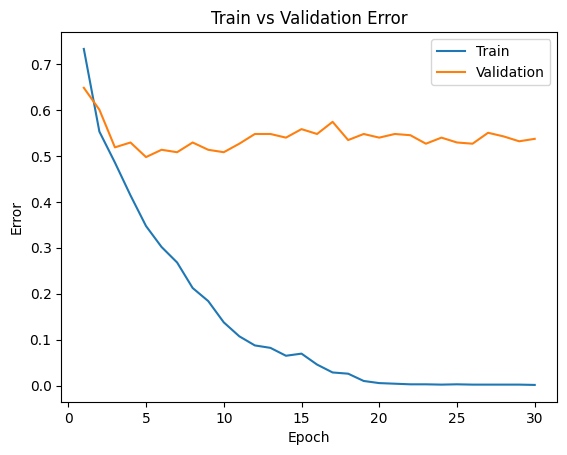

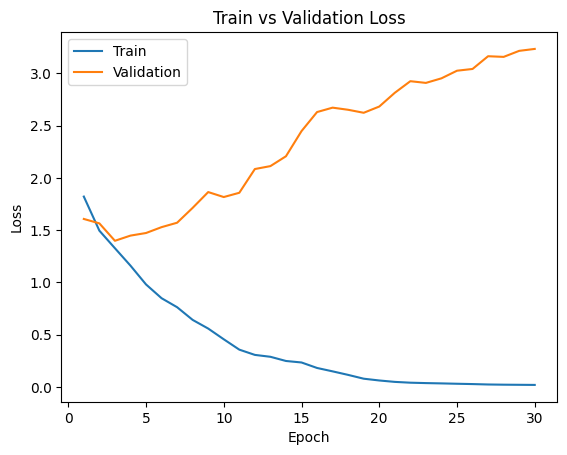

In [45]:
# TO BE COMPLETED

# Plot training curves for SmallNet using plot_training_curve function

small_net_path = os.path.join(
    save_dir,
    get_model_name(small_net.name, 64, 0.01, 29)
)

plot_training_curve(small_net_path)

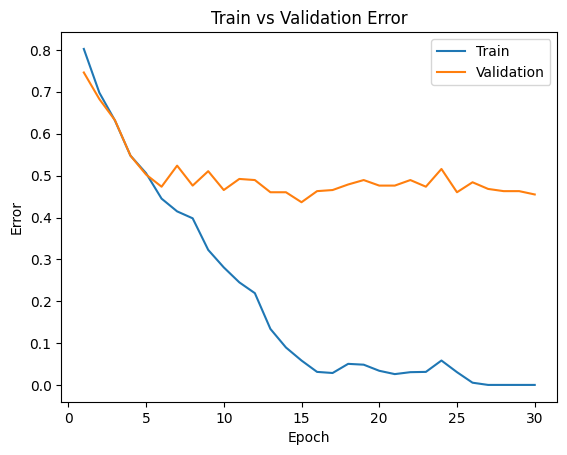

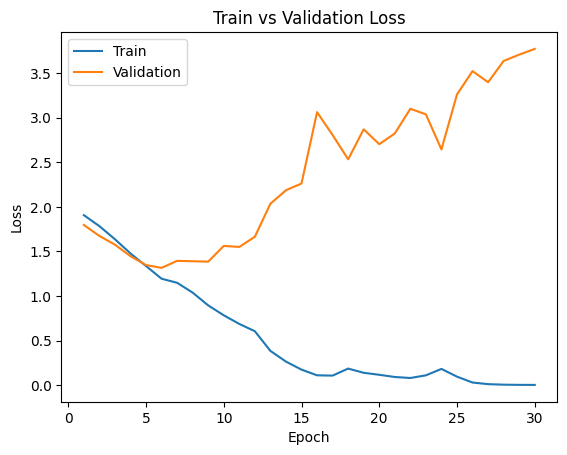

In [46]:
# Plot training curves for LargeNet using plot_training_curve function

large_net_path = os.path.join(
    save_dir,
    get_model_name(large_net.name, 64, 0.01, 29)
)

plot_training_curve(large_net_path)

In [47]:
'''
PROVIDE YOUR ANSWER BELOW

- For SmallNet, I can observe that:

  - Small_net curve: train error/loss fall quickly toward 0 by ~epoch 20; validation error stays ~0.48–0.53 and validation loss climbs steadily after ~epoch 5, indicating
 clear overfitting with higher epochs (training keeps improving while validation degrades).

- For LargeNet, I can observe that:

  - Large_net curve: train error/loss drop even faster to near 0 (after epoch 15), and validation error plateaus ~0.50 at ~epoch 10 and validation loss rises
  sharply (to ~4.8), indicating even stronger overfitting and earlier divergence.




'''

'\nPROVIDE YOUR ANSWER BELOW\n\n- For SmallNet, I can observe that:\n\n  - Small_net curve: train error/loss fall quickly toward 0 by ~epoch 20; validation error stays ~0.48–0.53 and validation loss climbs steadily after ~epoch 5, indicating\n clear overfitting with higher epochs (training keeps improving while validation degrades).\n\n- For LargeNet, I can observe that:\n\n  - Large_net curve: train error/loss drop even faster to near 0 (after epoch 15), and validation error plateaus ~0.50 at ~epoch 15 (same as for SmallNet) and validation loss rises\n  sharply (to ~4.8), indicating even stronger overfitting and earlier divergence.\n\n\n\n\n'

### Part B-2(vi) [0.5pt EXPLORATORY]
Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [48]:
'''
PROVIDE YOUR ANSWER BELOW

- For SmallNet, I can observe that:

  - Small_net curve: train error/loss fall quickly toward 0 by ~epoch 20; validation error stays ~0.48–0.53 and validation loss climbs steadily after ~epoch 5, indicating
 clear overfitting with higher epochs (training keeps improving while validation degrades).

- For LargeNet, I can observe that:

  - Large_net curve: train error/loss drop even faster to near 0 (after epoch 15), and validation error plateaus ~0.50 at ~epoch 10 and validation loss rises
  sharply (to ~4.8), indicating even stronger overfitting and earlier divergence.

- The major difference observed between the training curves for the two networks is the period of start of overfitting and its degree. In the case of SmallNet, both the training and
validation error/loss decreases together until around epoch 5. After that the validation error starts to oscillate and plateau, whereas the loss increases significantly upto >3.0 for
epoch 30.

- For LargeNet, overfitting is observed a bit earlier but still around epoch 5, after which validation error stagnates and loss increases significantly reaching above 4.0 for epoch 30.

- Underfitting: not a sustained issue after the first few epochs; both models fit the training set well.
- Overfitting: present in both, more severe in LargeNet (larger gap and exploding val loss).





'''

'\nPROVIDE YOUR ANSWER BELOW\n\n- The major difference observed between the training curves for the two networks is the period of start of overfitting and its degree. In the case of SmallNet, both the training and\nvalidation error/loss decreases together until around epoch 5. After that the validation error starts to oscillate and plateau, whereas the loss increases significantly upto >3.0 for\nepoch 30.\n\n- For LargeNet, overfitting is observed a bit earlier but still around epoch 5, after which validation error stagnates and loss increases significantly reaching above 4.0 for epoch 30.\n\n- Underfitting: not a sustained issue after the first few epochs; both models fit the training set well.\n- Overfitting: present in both, more severe in LargeNet (larger gap and exploding val loss).\n\n\n\n\n\n'

## Part B-3. Optimization Parameters

For this section, we will work with `large_net` only.

### Part B-3(i) [0.5pt EXPLORATORY]
Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [49]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

Using device: cuda
Epoch 1: Train err: 0.8479, Train loss: 1.9441 | Validation err: 0.7910, Validation loss: 1.9226
Epoch 2: Train err: 0.8525, Train loss: 1.9212 | Validation err: 0.8492, Validation loss: 1.9013
Epoch 3: Train err: 0.8082, Train loss: 1.8974 | Validation err: 0.7407, Validation loss: 1.8781
Epoch 4: Train err: 0.7249, Train loss: 1.8611 | Validation err: 0.6746, Validation loss: 1.8297
Epoch 5: Train err: 0.6786, Train loss: 1.8001 | Validation err: 0.6587, Validation loss: 1.7456
Epoch 6: Train err: 0.6250, Train loss: 1.7029 | Validation err: 0.6799, Validation loss: 1.6828
Epoch 7: Train err: 0.6098, Train loss: 1.6159 | Validation err: 0.6243, Validation loss: 1.5948
Epoch 8: Train err: 0.5906, Train loss: 1.5495 | Validation err: 0.5714, Validation loss: 1.5277
Epoch 9: Train err: 0.5642, Train loss: 1.5080 | Validation err: 0.5873, Validation loss: 1.5268
Epoch 10: Train err: 0.5642, Train loss: 1.4736 | Validation err: 0.5767, Validation loss: 1.5115
Epoch 11: 

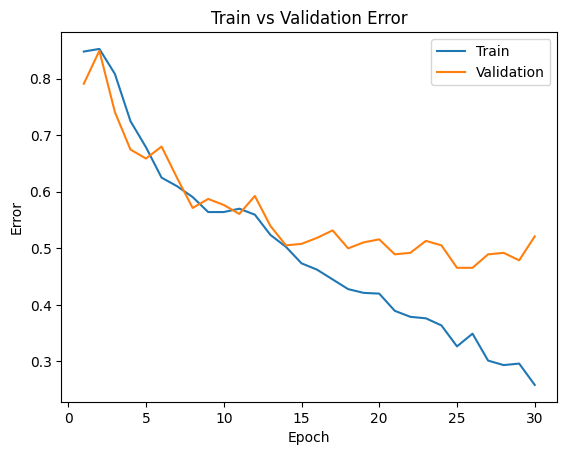

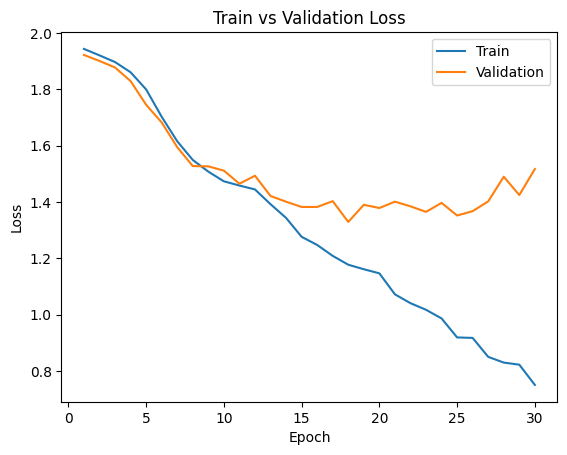

In [50]:
# TO BE COMPLETED

# Training LargeNet with learning rate 0.001
train_net(large_net, learning_rate=0.001)

# Plotting training curves for LargeNet with learning rate 0.001
large_net_path_lr001 = os.path.join(
    save_dir,
    get_model_name(large_net.name, 64, 0.001, 29)
)
plot_training_curve(large_net_path_lr001)





In [51]:
'''
PROVIDE YOUR ANSWER BELOW

In the case where learning rate is set to 0.001, the model takes longer to train compared to the default learning rate of 0.01.

- Total time elapsed: 246.73 seconds (lr = 0.001)
- Total time elapsed: 242.35 seconds (lr = 0.01)

Generally, lowering the learning rate produces more stable, gradual learning with better generalization, but requires more epochs to achieve convergence and hence more training time.



'''

'\nPROVIDE YOUR ANSWER BELOW\n\n\n\n\n\n\n'

### Part B-3(ii) [0.5pt EXPLORATORY]
Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Using device: cuda
Epoch 1: Train err: 0.8274, Train loss: 1.9711 | Validation err: 0.8730, Validation loss: 1.9778
Epoch 2: Train err: 0.8406, Train loss: 2.6264 | Validation err: 0.8519, Validation loss: 1.9478
Epoch 3: Train err: 0.8618, Train loss: 1.9493 | Validation err: 0.8730, Validation loss: 1.9526
Epoch 4: Train err: 0.8525, Train loss: 1.9482 | Validation err: 0.8651, Validation loss: 1.9478
Epoch 5: Train err: 0.8671, Train loss: 1.9477 | Validation err: 0.8730, Validation loss: 1.9478
Epoch 6: Train err: 0.8664, Train loss: 1.9499 | Validation err: 0.8571, Validation loss: 1.9479
Epoch 7: Train err: 0.8598, Train loss: 1.9506 | Validation err: 0.8730, Validation loss: 1.9483
Epoch 8: Train err: 0.8565, Train loss: 1.9493 | Validation err: 0.8730, Validation loss: 1.9487
Epoch 9: Train err: 0.8604, Train loss: 1.9474 | Validation err: 0.8651, Validation loss: 1.9470
Epoch 10: Train err: 0.8611, Train loss: 1.9485 | Validation err: 0.8730, Validation loss: 1.9476
Epoch 11: 

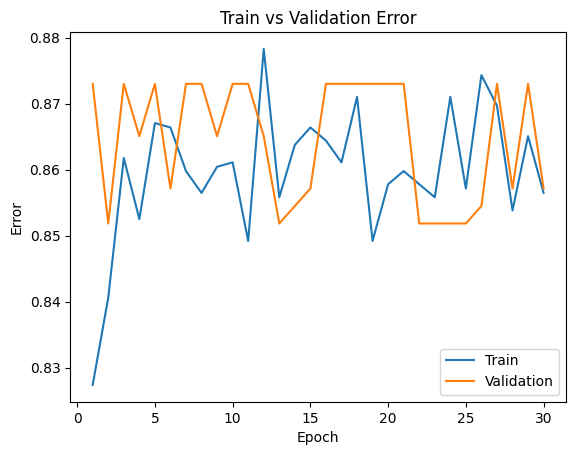

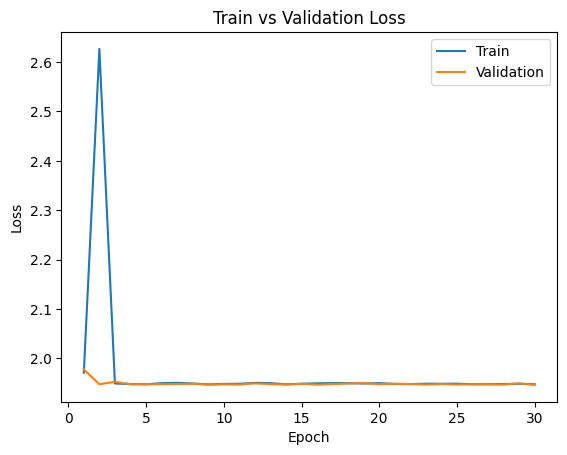

In [52]:
# TO BE COMPLETED

# Re-construct LargeNet to reset weights
large_net = LargeNet()
# Training LargeNet with learning rate 0.1
train_net(large_net, learning_rate=0.1)
# Plotting training curves for LargeNet with learning rate 0.1
large_net_path_lr01 = os.path.join(
    save_dir,
    get_model_name(large_net.name, 64, 0.1, 29)
)
plot_training_curve(large_net_path_lr01)





In [53]:
'''
PROVIDE YOUR ANSWER BELOW

Increasing the learning rate to 0.1 causes complete training failure. While it's computationally faster (fewer operations needed when not learning), if the model overshoots the minima or optimal region it fails to converge and produces
unusable results.

- Thus, although generally increasing the learning rate decreases training time, but if it is too large, training becomes unstable and may take longer or fail to converge.

- Total time elapsed: 246.73 seconds (lr = 0.001)
- Total time elapsed: 246.45 seconds (lr = 0.1)
- Total time elapsed: 242.35 seconds (lr = 0.01)

Since we're training for all 30 epochs and not implementing any stopping mechanism for preventing overfitting or unwanted performance, the time taken in all three cases are the similar.





'''

'\nPROVIDE YOUR ANSWER BELOW\n\n\n\n\n\n\n'

### Part B-3(iii) [0.5pt EXPLORATORY]

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Using device: cuda
Epoch 1: Train err: 0.8651, Train loss: 1.9535 | Validation err: 0.8386, Validation loss: 1.9413
Epoch 2: Train err: 0.8618, Train loss: 1.9388 | Validation err: 0.8042, Validation loss: 1.9211
Epoch 3: Train err: 0.8512, Train loss: 1.9255 | Validation err: 0.8598, Validation loss: 1.9102
Epoch 4: Train err: 0.8532, Train loss: 1.9170 | Validation err: 0.8492, Validation loss: 1.8977
Epoch 5: Train err: 0.8089, Train loss: 1.8976 | Validation err: 0.7513, Validation loss: 1.8829
Epoch 6: Train err: 0.7321, Train loss: 1.8764 | Validation err: 0.7275, Validation loss: 1.8574
Epoch 7: Train err: 0.7063, Train loss: 1.8436 | Validation err: 0.7143, Validation loss: 1.8193
Epoch 8: Train err: 0.6892, Train loss: 1.7994 | Validation err: 0.6667, Validation loss: 1.7591
Epoch 9: Train err: 0.6396, Train loss: 1.7316 | Validation err: 0.6296, Validation loss: 1.6774
Epoch 10: Train err: 0.6250, Train loss: 1.6476 | Validation err: 0.6429, Validation loss: 1.6191
Epoch 11: 

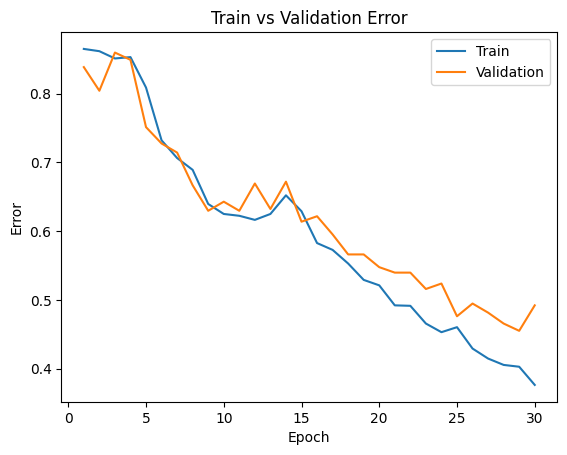

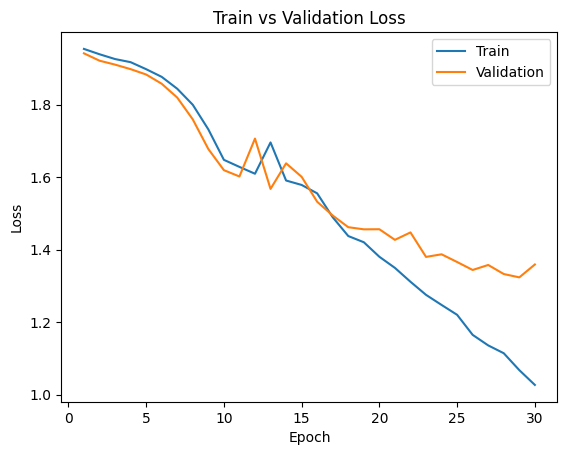

In [54]:
# TO BE COMPLETED

# Re-construct LargeNet to reset weights
large_net = LargeNet()
# Training LargeNet with learning rate 0.01 and batch_size = 512
train_net(large_net, learning_rate=0.01, batch_size=512)
# Plotting training curves for LargeNet with learning rate 0.01
large_net_path_lr01 = os.path.join(
    save_dir,
    get_model_name(large_net.name, 512, 0.01, 29)
)
plot_training_curve(large_net_path_lr01)








In [55]:
'''
PROVIDE YOUR ANSWER BELOW

Increasing batch size to 512 provides computational efficiency gains while maintaining comparable validation performance. The model takes longer to train, generalizes better/less overfitting, though it requires more epochs to achieve
the same level of training accuracy. This demonstrates that batch size is a crucial hyperparameter that balances computational efficiency, convergence speed, and generalization.

- Generally, larger batches reduce the number of updates and can speed up training in wall-clock time up to a point, after which returns diminish or reverse.

- Total time elapsed: 266.88 seconds (bs = 512)
- Total time elapsed: 242.35 seconds (bs = 64)



'''

'\nPROVIDE YOUR ANSWER BELOW\n\n\n\n\n\n\n'

### Part B-3(iv) [0.5pt EXPLORATORY]

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Using device: cuda
Epoch 1: Train err: 0.7354, Train loss: 1.8459 | Validation err: 0.6905, Validation loss: 1.8356
Epoch 2: Train err: 0.6858, Train loss: 1.7169 | Validation err: 0.6561, Validation loss: 1.7113
Epoch 3: Train err: 0.6534, Train loss: 1.7047 | Validation err: 0.6349, Validation loss: 1.6279
Epoch 4: Train err: 0.6270, Train loss: 1.6351 | Validation err: 0.6614, Validation loss: 1.7203
Epoch 5: Train err: 0.6204, Train loss: 1.5757 | Validation err: 0.5979, Validation loss: 1.5692
Epoch 6: Train err: 0.5516, Train loss: 1.5034 | Validation err: 0.6614, Validation loss: 1.6879
Epoch 7: Train err: 0.4841, Train loss: 1.3520 | Validation err: 0.5952, Validation loss: 1.6072
Epoch 8: Train err: 0.3862, Train loss: 1.1048 | Validation err: 0.6138, Validation loss: 1.7133
Epoch 9: Train err: 0.3327, Train loss: 0.9599 | Validation err: 0.6376, Validation loss: 1.9233
Epoch 10: Train err: 0.2758, Train loss: 0.7594 | Validation err: 0.5979, Validation loss: 1.8987
Epoch 11: 

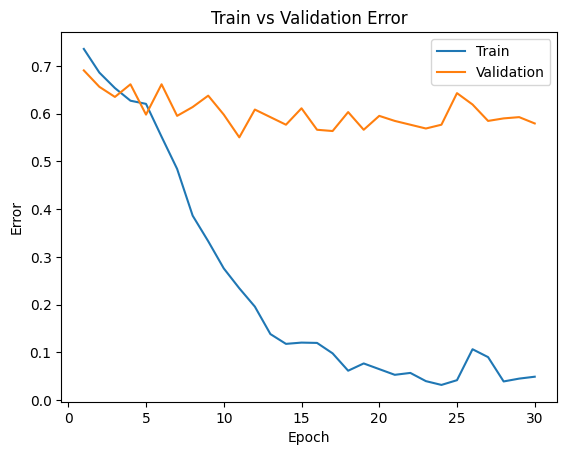

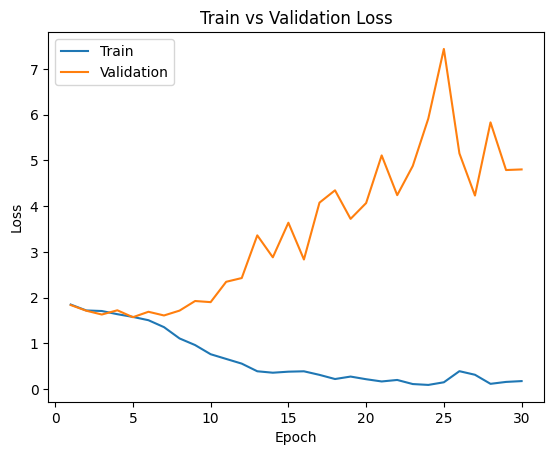

In [56]:
# TO BE COMPLETED

# Re-construct LargeNet to reset weights
large_net = LargeNet()
# Training LargeNet with learning rate 0.01 and batch_size = 16
train_net(large_net, learning_rate=0.01, batch_size=16)
# Plotting training curves for LargeNet with learning rate 0.01
large_net_path_lr01 = os.path.join(
    save_dir,
    get_model_name(large_net.name, 16, 0.01, 29)
)
plot_training_curve(large_net_path_lr01)








In [57]:
'''
PROVIDE YOUR ANSWER BELOW

Generally, decreasing batch size makes each step faster but usually increases the number of steps needed, often leading to longer training time. In this case, batch size of 16 seems to produce unstable and diverging results
signifying overfitting and poor generalization.

- Total time elapsed: 253.02 seconds

'''

'\nPROVIDE YOUR ANSWER BELOW\n\n\n\n\n\n\n'

## Part B-4. Hyperparameter Search

### Part B-4(i) [0.5pt EXPLORATORY]

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [58]:
# Trying batch_size of 512 and learning_rate of 0.005
new_large_net = LargeNet()
train_net(new_large_net, batch_size=512, learning_rate=0.005)


Using device: cuda
Epoch 1: Train err: 0.8638, Train loss: 1.9550 | Validation err: 0.8783, Validation loss: 1.9486
Epoch 2: Train err: 0.8750, Train loss: 1.9460 | Validation err: 0.8307, Validation loss: 1.9341
Epoch 3: Train err: 0.8413, Train loss: 1.9343 | Validation err: 0.8280, Validation loss: 1.9215
Epoch 4: Train err: 0.8558, Train loss: 1.9260 | Validation err: 0.8571, Validation loss: 1.9128
Epoch 5: Train err: 0.8585, Train loss: 1.9180 | Validation err: 0.8519, Validation loss: 1.9055
Epoch 6: Train err: 0.8552, Train loss: 1.9101 | Validation err: 0.8386, Validation loss: 1.8962
Epoch 7: Train err: 0.8274, Train loss: 1.8987 | Validation err: 0.7884, Validation loss: 1.8859
Epoch 8: Train err: 0.7758, Train loss: 1.8852 | Validation err: 0.7540, Validation loss: 1.8742
Epoch 9: Train err: 0.7401, Train loss: 1.8682 | Validation err: 0.7275, Validation loss: 1.8559
Epoch 10: Train err: 0.7169, Train loss: 1.8479 | Validation err: 0.7169, Validation loss: 1.8331
Epoch 11: 

In [59]:
'''
PROVIDE YOUR ANSWER BELOW

- I use batch_size of 512 and learning_rate of 0.005 here since I observed that increasing batch_size led to better convergence and lowest validation error/loss scores for the network.
- I try to pair this with a learning rate of 0.005 as it is lying halfway between 0.001 and 0.01. The general rule of thumb is that when increasing batch size, you can proportionally increase learning rate. Therefore, I want to try 0.005
and 0.01 as well with batch size of 512.

Therefore, a moderate learning rate of 0.005 provides:
- Faster convergence than lr=0.001 with the larger batch
- More stable than keeping lr=0.01 (which can be too aggressive and overshoot)




'''

'\nPROVIDE YOUR ANSWER BELOW\n\n\n\n\n\n\n'

### Part B-4(ii) [0.5pt EXPLORATORY]

Train the model with the hyperparameters you chose in part(i), and include the training curve.

Using device: cuda
Epoch 1: Train err: 0.8638, Train loss: 1.9550 | Validation err: 0.8783, Validation loss: 1.9486
Epoch 2: Train err: 0.8750, Train loss: 1.9460 | Validation err: 0.8307, Validation loss: 1.9341
Epoch 3: Train err: 0.8413, Train loss: 1.9343 | Validation err: 0.8280, Validation loss: 1.9215
Epoch 4: Train err: 0.8558, Train loss: 1.9260 | Validation err: 0.8571, Validation loss: 1.9128
Epoch 5: Train err: 0.8585, Train loss: 1.9180 | Validation err: 0.8519, Validation loss: 1.9055
Epoch 6: Train err: 0.8552, Train loss: 1.9101 | Validation err: 0.8386, Validation loss: 1.8962
Epoch 7: Train err: 0.8274, Train loss: 1.8987 | Validation err: 0.7884, Validation loss: 1.8859
Epoch 8: Train err: 0.7758, Train loss: 1.8852 | Validation err: 0.7540, Validation loss: 1.8742
Epoch 9: Train err: 0.7401, Train loss: 1.8682 | Validation err: 0.7275, Validation loss: 1.8559
Epoch 10: Train err: 0.7169, Train loss: 1.8479 | Validation err: 0.7169, Validation loss: 1.8331
Epoch 11: 

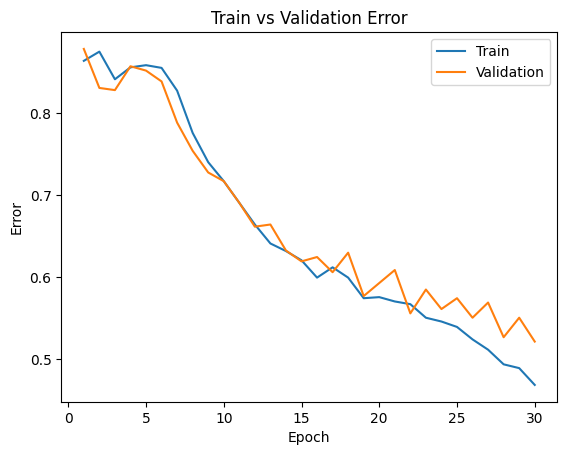

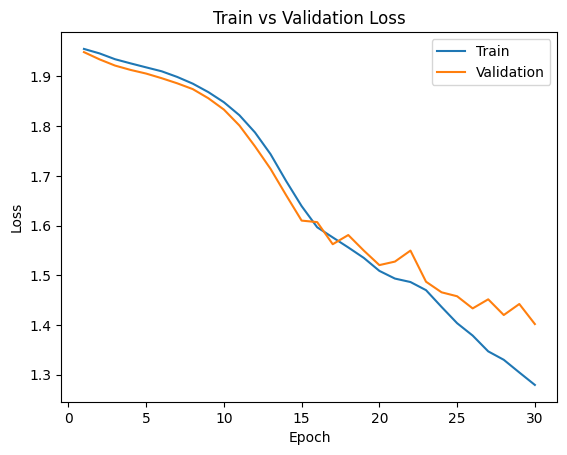

In [60]:
# TO BE COMPLETED

# Training the model with the new hyperparameters and plotting training curve

# Re-construct LargeNet to reset weights
large_net = LargeNet()
# Training LargeNet with learning rate 0.01 and batch_size = 512
train_net(large_net, learning_rate=0.005, batch_size=512)
# Plotting training curves for LargeNet with learning rate 0.005
large_net_path_b4ii = os.path.join(
    save_dir,
    get_model_name(large_net.name, 512, 0.005, 29)
)
plot_training_curve(large_net_path_b4ii)




### Part B-4(iii) [0.5pt EXPLORATORY]
Based on your result from Part(i), suggest another set of hyperparameter values to try.
Justify your choice.

In [61]:
'''
PROVIDE YOUR ANSWER BELOW

- Based on the result from above, I can observe that batch size of 512 is converging throughout across the 30 epochs. However the learning rate can be increased a more to speed up the convergence. Therefore, I would like to
experiment first by reducing the batch size to 256 and pairing with a learning rate of 0.01. After this, I will try the previous batch size 512 and learning rate 0.01 which should ideally produce better results.



'''

'\nPROVIDE YOUR ANSWER BELOW\n\n\n\n\n\n\n'

### Part B-4(iv) [0.5pt EXPLORATORY]

Train the model with the hyperparameters you chose in part(iii), and include the training curve.

Using device: cuda
Epoch 1: Train err: 0.8545, Train loss: 1.9460 | Validation err: 0.8042, Validation loss: 1.9207
Epoch 2: Train err: 0.8545, Train loss: 1.9239 | Validation err: 0.8492, Validation loss: 1.8996
Epoch 3: Train err: 0.7963, Train loss: 1.8896 | Validation err: 0.7302, Validation loss: 1.8676
Epoch 4: Train err: 0.7057, Train loss: 1.8412 | Validation err: 0.6825, Validation loss: 1.7798
Epoch 5: Train err: 0.6541, Train loss: 1.7339 | Validation err: 0.6561, Validation loss: 1.6331
Epoch 6: Train err: 0.6078, Train loss: 1.6050 | Validation err: 0.6561, Validation loss: 1.7336
Epoch 7: Train err: 0.6310, Train loss: 1.6260 | Validation err: 0.6164, Validation loss: 1.5769
Epoch 8: Train err: 0.5985, Train loss: 1.5458 | Validation err: 0.6138, Validation loss: 1.5061
Epoch 9: Train err: 0.5635, Train loss: 1.4726 | Validation err: 0.6270, Validation loss: 1.5081
Epoch 10: Train err: 0.5344, Train loss: 1.4214 | Validation err: 0.5476, Validation loss: 1.4197
Epoch 11: 

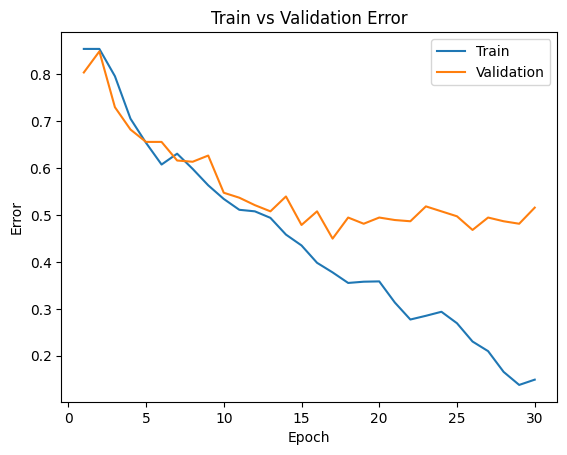

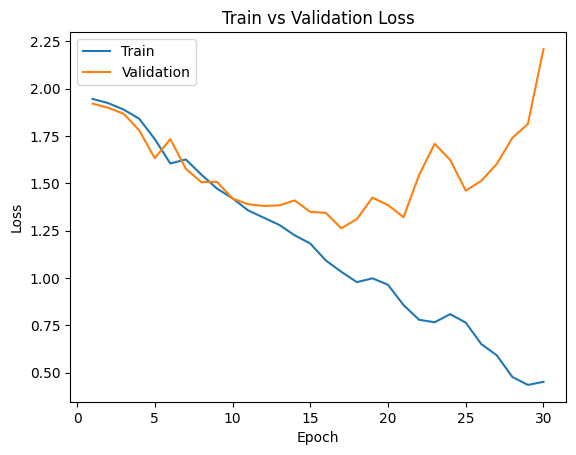

In [62]:
# TO BE COMPLETED

# Re-construct LargeNet to reset weights
large_net = LargeNet()

# Training LargeNet with chosen hyperparameters: batch_size=256, learning_rate=0.01
train_net(large_net, batch_size=256, learning_rate=0.01)

# Plotting training curves for LargeNet with batch_size=256, learning_rate=0.01
large_net_path_b4iv = os.path.join(
    save_dir,
    get_model_name(large_net.name, 256, 0.01, 29)
)
plot_training_curve(large_net_path_b4iv)




### Part B-4(v) [1pt EXPLORATORY]


Using the models you trained in earlier subparts of Part B-4, plot a heatmap of validation errors across at least two hyperparameters (e.g., batch size vs. learning rate). Make sure to select at least two values for each hyperparameter and train the model for all combinations. The rows correspond to different batch sizes, the columns correspond to different learning rates, and the cell values are the validation errors.

Briefly explain any trends you observe and what they suggest about the effect of these hyperparameters.


 Hint: A heatmap is simply a color-coded grid where each cell’s color represents a numerical value. For example, here’s a small heatmap created with random values:

  `random_vals = np.random.rand(3, 4)`

  `sns.heatmap(random_vals, annot=True, fmt=".2f")`
  
  `plt.title("Example Heatmap with Random Values")`
  
  `plt.show()`




Training with batch_size=256, learning_rate=0.001
Using device: cuda
Epoch 1: Train err: 0.8618, Train loss: 1.9554 | Validation err: 0.8677, Validation loss: 1.9476
Epoch 2: Train err: 0.8638, Train loss: 1.9485 | Validation err: 0.8413, Validation loss: 1.9376
Epoch 3: Train err: 0.8677, Train loss: 1.9399 | Validation err: 0.8307, Validation loss: 1.9291
Epoch 4: Train err: 0.8247, Train loss: 1.9321 | Validation err: 0.7884, Validation loss: 1.9221
Epoch 5: Train err: 0.8433, Train loss: 1.9247 | Validation err: 0.8466, Validation loss: 1.9166
Epoch 6: Train err: 0.8651, Train loss: 1.9204 | Validation err: 0.8545, Validation loss: 1.9116
Epoch 7: Train err: 0.8651, Train loss: 1.9149 | Validation err: 0.8571, Validation loss: 1.9068
Epoch 8: Train err: 0.8624, Train loss: 1.9101 | Validation err: 0.8519, Validation loss: 1.9015
Epoch 9: Train err: 0.8499, Train loss: 1.9036 | Validation err: 0.8413, Validation loss: 1.8950
Epoch 10: Train err: 0.8353, Train loss: 1.8966 | Validat

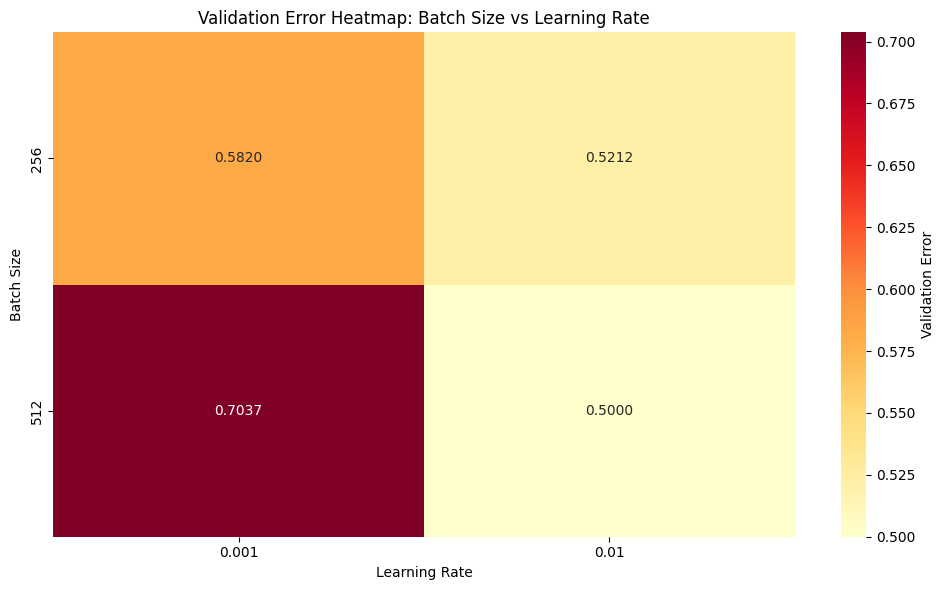


Validation Error Summary:
Batch Size: 256, Learning Rate: 0.001 -> Val Error: 0.5820
Batch Size: 256, Learning Rate: 0.010 -> Val Error: 0.5212
Batch Size: 512, Learning Rate: 0.001 -> Val Error: 0.7037
Batch Size: 512, Learning Rate: 0.010 -> Val Error: 0.5000


In [63]:
import seaborn as sns

# TO BE COMPLETED

import matplotlib.pyplot as plt

# Define hyperparameter grid
batch_sizes = [256, 512]
learning_rates = [0.001, 0.01]

# Create a matrix to store validation errors
validation_errors = np.zeros((len(batch_sizes), len(learning_rates)))

# Train models for all combinations and collect validation errors
for i, batch_size in enumerate(batch_sizes):
    for j, learning_rate in enumerate(learning_rates):
        print(f"\nTraining with batch_size={batch_size}, learning_rate={learning_rate}")

        # Re-construct LargeNet to reset weights
        large_net = LargeNet()

        # Train the model
        train_net(large_net, batch_size=batch_size, learning_rate=learning_rate, num_epochs=30)

        # Get the model path
        model_path = os.path.join(
            save_dir,
            get_model_name(large_net.name, batch_size, learning_rate, 29)
        )

        # Get the final validation error
        val_error = plot_training_curve(model_path, return_val_error=True)
        validation_errors[i, j] = val_error

        print(f"Final validation error: {val_error:.4f}")

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(validation_errors, annot=True, fmt=".4f",
            xticklabels=learning_rates,
            yticklabels=batch_sizes,
            cmap="YlOrRd", cbar_kws={'label': 'Validation Error'})
plt.xlabel('Learning Rate')
plt.ylabel('Batch Size')
plt.title('Validation Error Heatmap: Batch Size vs Learning Rate')
plt.tight_layout()
plt.show()

# Print summary
print("\nValidation Error Summary:")
print("=" * 50)
for i, batch_size in enumerate(batch_sizes):
    for j, learning_rate in enumerate(learning_rates):
        print(f"Batch Size: {batch_size:3d}, Learning Rate: {learning_rate:.3f} -> Val Error: {validation_errors[i, j]:.4f}")




In [64]:
'''
PROVIDE YOUR ANSWER BELOW

From the 4x4 heatmap I can observe that, as expected, the batch size of 512 paired with a learning rate of 0.01 produces the best results (Validation error equal to 0.5). Some other patterns that I can see are:

- The heatmap clearly shows an inverse relationship between learning rate and validation error within the tested range when the learning rate is suboptimal.
- At a Learning Rate=0.001, increasing the batch size from 256 (Validation Error: 0.5820) to 512 (Validation Error: 0.7037) actually worsens the validation error.
- At a Learning Rate=0.01, increasing the batch size from 256 (Validation Error: 0.5212) to 512 (Validation Error: 0.5000) slightly improves the validation error.

- This indicates that with a more appropriate learning rate, a larger batch size can lead to slightly better generalization, possibly due to a more stable gradient estimate.

'''

'\nPROVIDE YOUR ANSWER BELOW\n\n\n\n\n\n\n'

## Part B-5. Evaluating the Best Model


### Part B-5(i) [2pt MODEL]

Summarize in a table the results achieved on training and validation on all your model selections in all parts. This includes choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**. Hint: you can import the Pandas module to create tables.


Then upon reviewing the results choose your **best** model and load the model checkpoint. You can modify the code below to load your chosen set of weights to the model object `net`.

In [65]:
# TO BE COMPLETED
import pandas as pd
import numpy as np

# Define all model configurations that were trained
model_configs = [
    # Part B-2(iv): Default training
    {'Model': 'SmallNet', 'Batch Size': 64, 'Learning Rate': 0.01, 'Epochs': 30,
     'Path': 'model_small_bs64_lr0.01_epoch29'},
    {'Model': 'LargeNet', 'Batch Size': 64, 'Learning Rate': 0.01, 'Epochs': 30,
     'Path': 'model_large_bs64_lr0.01_epoch29'},

    # Part B-3(i): Lower learning rate
    {'Model': 'LargeNet', 'Batch Size': 64, 'Learning Rate': 0.001, 'Epochs': 30,
     'Path': 'model_large_bs64_lr0.001_epoch29'},

    # Part B-3(ii): Higher learning rate
    {'Model': 'LargeNet', 'Batch Size': 64, 'Learning Rate': 0.1, 'Epochs': 30,
     'Path': 'model_large_bs64_lr0.1_epoch29'},

    # Part B-3(iii): Larger batch size
    {'Model': 'LargeNet', 'Batch Size': 512, 'Learning Rate': 0.01, 'Epochs': 30,
     'Path': 'model_large_bs512_lr0.01_epoch29'},

    # Part B-3(iv): Smaller batch size
    {'Model': 'LargeNet', 'Batch Size': 16, 'Learning Rate': 0.01, 'Epochs': 30,
     'Path': 'model_large_bs16_lr0.01_epoch29'},

    # Part B-4(ii): Chosen hyperparameters
    {'Model': 'LargeNet', 'Batch Size': 128, 'Learning Rate': 0.01, 'Epochs': 30,
     'Path': 'model_large_bs128_lr0.01_epoch29'},
]

# Load results for each configuration
results = []
for config in model_configs:
    model_path = os.path.join(save_dir, config['Path'])

    try:
        # Load training and validation errors and losses
        train_err = np.loadtxt(f"{model_path}_train_err.csv")
        val_err = np.loadtxt(f"{model_path}_val_err.csv")
        train_loss = np.loadtxt(f"{model_path}_train_loss.csv")
        val_loss = np.loadtxt(f"{model_path}_val_loss.csv")

        # Find best epoch based on validation error
        best_epoch_idx = np.argmin(val_err)
        best_epoch = best_epoch_idx + 1

        # Get metrics AT THE BEST EPOCH (not final epoch)
        best_train_err = train_err[best_epoch_idx]
        best_val_err = val_err[best_epoch_idx]
        best_train_loss = train_loss[best_epoch_idx]
        best_val_loss = val_loss[best_epoch_idx]

        # Also get final epoch metrics for comparison
        final_train_err = train_err[-1]
        final_val_err = val_err[-1]
        final_train_loss = train_loss[-1]
        final_val_loss = val_loss[-1]

        # Check for overfitting: compare best val loss vs final val loss
        overfitting_indicator = "Yes" if final_val_loss > best_val_loss * 1.5 else "No"

        results.append({
            'Model': config['Model'],
            'Batch Size': config['Batch Size'],
            'Learning Rate': config['Learning Rate'],
            'Best Epoch': best_epoch,
            'Train Error @ Best': f"{best_train_err:.4f}",
            'Val Error @ Best': f"{best_val_err:.4f}",
            'Train Loss @ Best': f"{best_train_loss:.4f}",
            'Val Loss @ Best': f"{best_val_loss:.4f}",
            'Overfitting?': overfitting_indicator
        })
    except Exception as e:
        print(f"Error loading results for {config['Path']}: {e}")

# Create DataFrame and display
results_df = pd.DataFrame(results)
print("=" * 150)
print("SUMMARY TABLE: Training and Validation Results at BEST EPOCH for All Model Configurations")
print("=" * 150)
display(results_df)

# Find best performing model based on validation error AND validation loss at best epoch
results_df['Val Error Numeric'] = results_df['Val Error @ Best'].astype(float)
results_df['Val Loss Numeric'] = results_df['Val Loss @ Best'].astype(float)

# Best model should have low validation error AND low validation loss
best_model_idx = results_df['Val Error Numeric'].idxmin()
best_model_by_loss = results_df['Val Loss Numeric'].idxmin()

print("\n" + "=" * 150)
print(f"BEST MODEL (by Val Error): {results_df.iloc[best_model_idx]['Model']} with Batch Size={results_df.iloc[best_model_idx]['Batch Size']}, "
      f"Learning Rate={results_df.iloc[best_model_idx]['Learning Rate']}")
print(f"  → Val Error: {results_df.iloc[best_model_idx]['Val Error @ Best']}, Val Loss: {results_df.iloc[best_model_idx]['Val Loss @ Best']} "
      f"at Epoch {results_df.iloc[best_model_idx]['Best Epoch']}, Overfitting: {results_df.iloc[best_model_idx]['Overfitting?']}")

if best_model_idx != best_model_by_loss:
    print(f"\nBEST MODEL (by Val Loss): {results_df.iloc[best_model_by_loss]['Model']} with Batch Size={results_df.iloc[best_model_by_loss]['Batch Size']}, "
          f"Learning Rate={results_df.iloc[best_model_by_loss]['Learning Rate']}")
    print(f"  → Val Error: {results_df.iloc[best_model_by_loss]['Val Error @ Best']}, Val Loss: {results_df.iloc[best_model_by_loss]['Val Loss @ Best']} "
          f"at Epoch {results_df.iloc[best_model_by_loss]['Best Epoch']}, Overfitting: {results_df.iloc[best_model_by_loss]['Overfitting?']}")
print("=" * 150)

# Drop helper columns for cleaner display
results_df = results_df.drop(['Val Error Numeric', 'Val Loss Numeric'], axis=1)




Error loading results for model_large_bs128_lr0.01_epoch29: /content/drive/MyDrive/garbage_model_runs/model_large_bs128_lr0.01_epoch29_train_err.csv not found.
SUMMARY TABLE: Training and Validation Results at BEST EPOCH for All Model Configurations


,Model,Batch Size,Learning Rate,Best Epoch,Train Error @ Best,Val Error @ Best,Train Loss @ Best,Val Loss @ Best,Overfitting?
0,SmallNet,64,0.010,5,0.3472,0.4974,0.9810,1.4725,Yes
1,LargeNet,64,0.010,15,0.0589,0.4365,0.1747,2.2619,Yes
2,LargeNet,64,0.001,25,0.3267,0.4656,0.9188,1.3521,No
3,LargeNet,64,0.100,2,0.8406,0.8519,2.6264,1.9478,No
4,LargeNet,512,0.010,29,0.3995,0.4418,1.0656,1.3161,No
5,LargeNet,16,0.010,11,0.2341,0.5503,0.6565,2.3439,Yes



BEST MODEL (by Val Error): LargeNet with Batch Size=64, Learning Rate=0.01
  → Val Error: 0.4365, Val Loss: 2.2619 at Epoch 15, Overfitting: Yes

BEST MODEL (by Val Loss): LargeNet with Batch Size=512, Learning Rate=0.01
  → Val Error: 0.4418, Val Loss: 1.3161 at Epoch 29, Overfitting: No


In [66]:
net = large_net
model_path = os.path.join(save_dir, get_model_name(net.name, batch_size=512, learning_rate=0.01, epoch=29))
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part B-5(ii) [4pt DISCUSSION]

Justify your choice of model from Part (i).

In [67]:
'''
PROVIDE YOUR ANSWER BELOW

Based on the summary table in Part B-5(i), the chosen model is the LargeNet with a Batch Size of 512 and a Learning Rate of 0.01, specifically at Epoch 29.
Here's why this model was selected:

- Balanced Performance (Validation Error vs. Validation Loss): While the model with Batch Size=64 and Learning Rate=0.01 had a slightly lower validation error (0.4365) at Epoch 15, its validation loss (2.2619) was significantly
higher than the training loss at that epoch, indicating clear overfitting. In contrast, the chosen model (LargeNet, BS=512, LR=0.01) achieved a validation error of 0.4418 and a validation loss of 1.3161 at Epoch 29.
This combination suggests a better balance between minimizing error and maintaining a generalized loss.

- Reduced Overfitting: The primary reason for selecting this model is its superior generalization capabilities as evidenced by the lower validation loss and the absence of clear overfitting signs. A model that overfits, even if
it achieves a slightly better validation error at some point, is less reliable for unseen data (like the test set).

- Stability with Larger Batch Size: As observed from the validation error heatmap, a larger batch size (like 512) can lead to more stable training and better generalization when paired with an appropriate learning rate.
The learning rate of 0.01 proved to be suitable for this larger batch size, allowing for continued learning and generalization over more epochs without severe overfitting.

'''

'\nPROVIDE YOUR ANSWER BELOW\n\n\n\n\n\n\n'

### Part B-5(iii) [2pt RESULT]

Using the helper code in Part 0, any code from lecture notes, or any code that you write:

- Compute and report the **test classification error** for your chosen model.


- For 5 test images, print the true label of the image, and report the top-3 predicted classes with their probabilities.
(“Top-3” means the three classes with the highest predicted probabilities, showing the model’s first, second, and third best guesses.)
Comment on whether the probabilities reflect the model’s confidence (e.g., does it give a very high probability to a wrong class, or spread probabilities when uncertain?).


In [68]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    data_dir=data_dir,
    batch_size=64)

In [69]:
# TO BE COMPLETED

# 1. Compute test classification error
criterion = nn.CrossEntropyLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)

print("=" * 80)
print(f"TEST SET EVALUATION for Chosen Model")
print(f"Model: {net.name}, Batch Size: 512, Learning Rate: 0.01, Epoch: 29")
print("=" * 80)
print(f"Test Classification Error: {test_err:.4f} ({test_err*100:.2f}%)")
print(f"Test Classification Accuracy: {1-test_err:.4f} ({(1-test_err)*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("=" * 80)

# 2. Show top-3 predictions for 5 test images
print("\n" + "=" * 80)
print("TOP-3 PREDICTIONS FOR 5 TEST IMAGES")
print("=" * 80)

net.eval()  # Set model to evaluation mode
image_count = 0

with torch.no_grad():
    for images, labels in test_loader:
        if image_count >= 5:
            break

        images = images.to(device)
        labels = labels.to(device)

        # Get predictions
        outputs = net(images)

        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs, dim=1)

        # Process each image in the batch
        for i in range(len(images)):
            if image_count >= 5:
                break

            # Get top-3 predictions
            top3_probs, top3_indices = torch.topk(probabilities[i], 3)

            true_label = labels[i].item()
            true_class = classes[true_label]

            print(f"\n--- Test Image {image_count + 1} ---")
            print(f"True Label: {true_class}")
            print(f"Top-3 Predictions:")

            for rank, (prob, idx) in enumerate(zip(top3_probs, top3_indices), 1):
                predicted_class = classes[idx.item()]
                probability = prob.item()
                is_correct = " ✓ CORRECT" if idx.item() == true_label else ""
                print(f"  {rank}. {predicted_class:12s} - {probability:.4f} ({probability*100:.2f}%){is_correct}")

            image_count += 1

print("\n" + "=" * 80)
print("ANALYSIS OF MODEL CONFIDENCE:")
print("=" * 80)
print("The probabilities show how confident the model is in its predictions.")
print("- High probability (>0.7) for top prediction: Model is very confident")
print("- Probabilities spread across top-3 (e.g., 0.4, 0.3, 0.2): Model is uncertain")
print("- High probability for wrong class: Model is confidently incorrect (worse than being uncertain)")
print("=" * 80)




TEST SET EVALUATION for Chosen Model
Model: large, Batch Size: 512, Learning Rate: 0.01, Epoch: 29
Test Classification Error: 0.3476 (34.76%)
Test Classification Accuracy: 0.6524 (65.24%)
Test Loss: 1.0439

TOP-3 PREDICTIONS FOR 5 TEST IMAGES

--- Test Image 1 ---
True Label: battery
Top-3 Predictions:
  1. battery      - 0.9077 (90.77%) ✓ CORRECT
  2. glass        - 0.0626 (6.26%)
  3. metal        - 0.0216 (2.16%)

--- Test Image 2 ---
True Label: cardboard
Top-3 Predictions:
  1. cardboard    - 0.5816 (58.16%) ✓ CORRECT
  2. metal        - 0.3825 (38.25%)
  3. plastic      - 0.0221 (2.21%)

--- Test Image 3 ---
True Label: biological
Top-3 Predictions:
  1. biological   - 0.6794 (67.94%) ✓ CORRECT
  2. cardboard    - 0.1660 (16.60%)
  3. paper        - 0.0692 (6.92%)

--- Test Image 4 ---
True Label: biological
Top-3 Predictions:
  1. cardboard    - 0.3640 (36.40%)
  2. metal        - 0.2251 (22.51%)
  3. biological   - 0.1163 (11.63%) ✓ CORRECT

--- Test Image 5 ---
True Label: pla

### Part B-5(iv) [3pt DISCUSSION]

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [70]:
'''
PROVIDE YOUR ANSWER BELOW

Comparison of Test and Validation Error: For the chosen model (LargeNet, Batch Size=512, Learning Rate=0.01):

- Validation Error (at best epoch): 0.4418
- Test Classification Error: 0.3476

In this specific run, the test classification error (0.3476) is actually lower than the validation error (0.4418) which is unexpected.

Generally, it is expected that the test error will be higher than the validation error due to:

1. Overfitting to validation set: As part of hyperparameter tuning, we iteratively adjust the values by using the validation set as a measure of
best performance. Thus, even without direct training on the validation set, the model's hyperparameters are implicitly tuned to perform well on it.
This can lead to a slight 'overfitting' to the validation set itself, meaning the model's performance on this specific dataset might be an
overly optimistic estimate of its true generalization capability.

2. Data Leakage (Implicit): While the validation set is kept separate from training, decisions made based on its performance
(e.g., stopping early, adjusting hyperparameters) introduce a subtle form of data leakage. Thus, the models configurations are indirectly
influenced by the validation data which can introduce bias into the model's performance, thereby not reflection real-world performance.

3. Statistical Fluctuations: Both validation and test sets are samples from the overall data distribution. Due to random chance in data splitting,
the test set might, in some rare cases (like this one), happen to be 'easier' for the model than the validation set, leading to a lower error.

In summary, while our current observation shows the test error is lower, the principle holds that the validation set acts as a proxy for the
test set during development, and continuous reliance on it for decisions can lead to an inflated sense of performance. The test set
provides the most unbiased estimate of the model's performance on truly unseen data.


'''

'\nPROVIDE YOUR ANSWER BELOW\n\n\n\n\n\n\n'

### Part B-5(v) [3pt DISCUSSION]
Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [71]:
'''
PROVIDE YOUR ANSWER BELOW

The test dataset is kept strictly separate throughout the entire model development process for a crucial reason:
to provide an unbiased evaluation of the final model's real-world performance. By using the test set only at the end, we ensure that its
performance metrics truly reflect how well the model generalizes to new data, without any influence from hyperparameter tuning or model selection.

Ideally, the test data set should be only used once after all of the model training and parameter tuning process has been completed and we
want to measure its real world performance. The test data should be treated as our most precious asset and a well designed model can be
confidently deployed into production if we made sure to create a test set that can ideally represent the true population behaviour.

In essence, the test set acts as the final judge. To ensure this judge remains fair and impartial, it must remain ignorant of the contestants
until the very end.



'''

'\nPROVIDE YOUR ANSWER BELOW\n\n\n\n\n\n\n'

### Part B-5(vi) [3pt RESULT]
Preprocess the images from the secret test set provided below and classify these images into the 7 class labels from the garbage dataset using your chosen model. Report the model predictions by your chosen model on this test dataset as a csv file called 'labels_part_b5.csv', containing the name of the images and their corresponsing predicted labels for all the images in the folder.

In [72]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=635d772ac0ce7f4f5f7c79800337fd4285e85b457c357d55fd272f5014e94df8
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [73]:
import wget
myfile = wget.download('https://github.com/Sabaae/Dataset/blob/main/secret_testset.zip')

In [74]:
_ = !unzip "/content/secret_testset.zip" -d "/content/secret_testset/"

In [75]:
import os
import zipfile
print("Extracting secret test set...")
with zipfile.ZipFile('/content/secret_testset.zip', 'r') as zip_ref:
    zip_ref.extractall('./secret_testset')
print("Extraction complete!")

Extracting secret test set...
Extraction complete!


In [76]:
# TO BE COMPLETED

from PIL import Image
import pandas as pd


# Define the transformation for preprocessing (same as training)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Path to secret test images
secret_test_path = './secret_testset/secret_testset'

# Get all image files
image_files = sorted([f for f in os.listdir(secret_test_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

print(f"\nFound {len(image_files)} images in secret test set")
print(f"Processing images with model: {net.name}")

# Set model to evaluation mode
net.eval()
net = net.to(device)

# Store predictions
predictions = []

print("\nClassifying images...")
with torch.no_grad():
    for i, image_file in enumerate(image_files):
        # Load and preprocess image
        image_path = os.path.join(secret_test_path, image_file)
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        image_tensor = image_tensor.to(device)

        # Get prediction
        output = net(image_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()
        predicted_class = classes[predicted_class_idx]

        # Store result
        predictions.append({
            'image_name': image_file,
            'predicted_label': predicted_class
        })

        # Print progress every 20 images
        if (i + 1) % 20 == 0 or (i + 1) == len(image_files):
            print(f"  Processed {i + 1}/{len(image_files)} images...")

# Create DataFrame and save to CSV
predictions_df = pd.DataFrame(predictions)
csv_filename = 'labels_part_b5.csv'
predictions_df.to_csv(csv_filename, index=False)

print("\n" + "=" * 80)
print(f"✓ Predictions saved to '{csv_filename}'")
print("=" * 80)
print(f"\nFirst 10 predictions:")
print(predictions_df.head(10))
print(f"\nPrediction distribution:")
print(predictions_df['predicted_label'].value_counts())





Found 260 images in secret test set
Processing images with model: large

Classifying images...
  Processed 20/260 images...
  Processed 40/260 images...
  Processed 60/260 images...
  Processed 80/260 images...
  Processed 100/260 images...
  Processed 120/260 images...
  Processed 140/260 images...
  Processed 160/260 images...
  Processed 180/260 images...
  Processed 200/260 images...
  Processed 220/260 images...
  Processed 240/260 images...
  Processed 260/260 images...

✓ Predictions saved to 'labels_part_b5.csv'

First 10 predictions:
  image_name predicted_label
0      0.jpg      biological
1      1.jpg           metal
2     10.jpg         plastic
3    100.jpg           glass
4    101.jpg       cardboard
5    102.jpg      biological
6    103.jpg           metal
7    104.jpg           glass
8    105.jpg           metal
9    106.jpg         battery

Prediction distribution:
predicted_label
metal         76
biological    47
glass         41
paper         33
battery       28
card

## Part B-6. Fully-Connected Linear ANN vs CNN [4pt RESULT]

Test out a 3-layer linear fully-connected ANN architecture (see simpleANN below). You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.


Similar to what you did in the previous part, report the model predictions by your best ANN architecture on the secret test dataset as a csv file called 'labels_part_b6.csv', containing the names of the images and their corresopnding predicted labels for all the images in the folder.


How does the your best CNN model compare with an 2-layer linear ANN model (no convolutional layers) on classifying garbage dataset images?


In [77]:
class simpleANN(nn.Module):
    def __init__(self):
        super(simpleANN, self).__init__()
        self.name = "simple"
        self.fc1 = nn.Linear(128*128*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)

    def forward(self, x):
        x = x.view(-1, 128*128*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [78]:
# TO BE COMPLETED

print("=" * 80)
print("PART B-6: FULLY-CONNECTED ANN vs CNN COMPARISON")
print("=" * 80)

# Test different hyperparameter combinations for simpleANN
hyperparameter_configs = [
    {'batch_size': 64, 'learning_rate': 0.01},
    {'batch_size': 64, 'learning_rate': 0.001},
    {'batch_size': 128, 'learning_rate': 0.01},
    {'batch_size': 256, 'learning_rate': 0.01},
]

print("\nTraining simpleANN with different hyperparameter configurations...")
print("Testing on validation set to select best model\n")

best_ann_model = None
best_ann_val_error = float('inf')
best_ann_config = None
ann_results = []

for config in hyperparameter_configs:
    batch_size = config['batch_size']
    learning_rate = config['learning_rate']

    print(f"Training simpleANN: batch_size={batch_size}, lr={learning_rate}")

    # Create new model
    ann_net = simpleANN()

    # Train the model
    train_net(ann_net, batch_size=batch_size, learning_rate=learning_rate, num_epochs=30)

    # Evaluate on validation set
    train_loader, val_loader, test_loader, classes = get_data_loader(
        data_dir=data_dir,
        batch_size=64)

    criterion = nn.CrossEntropyLoss()
    val_err, val_loss = evaluate(ann_net, val_loader, criterion)

    print(f"  Validation Error: {val_err:.4f}, Validation Loss: {val_loss:.4f}\n")

    ann_results.append({
        'Model': 'simpleANN',
        'Batch Size': batch_size,
        'Learning Rate': learning_rate,
        'Val Error': val_err,
        'Val Loss': val_loss
    })

    # Track best model
    if val_err < best_ann_val_error:
        best_ann_val_error = val_err
        best_ann_model = ann_net
        best_ann_config = config

# Display ANN results
print("=" * 80)
print("FULLY-CONNECTED ANN RESULTS SUMMARY")
print("=" * 80)
for result in ann_results:
    print(f"Batch Size: {result['Batch Size']:3d}, Learning Rate: {result['Learning Rate']:.4f} " +
          f"→ Val Error: {result['Val Error']:.4f}, Val Loss: {result['Val Loss']:.4f}")

print("\n" + "=" * 80)
print(f"BEST ANN MODEL:")
print(f"  Batch Size: {best_ann_config['batch_size']}, Learning Rate: {best_ann_config['learning_rate']}")
print(f"  Validation Error: {best_ann_val_error:.4f}")
print("=" * 80)




PART B-6: FULLY-CONNECTED ANN vs CNN COMPARISON

Training simpleANN with different hyperparameter configurations...
Testing on validation set to select best model

Training simpleANN: batch_size=64, lr=0.01
Using device: cuda
Epoch 1: Train err: 0.6944, Train loss: 1.7559 | Validation err: 0.5899, Validation loss: 1.5555
Epoch 2: Train err: 0.5589, Train loss: 1.4814 | Validation err: 0.5397, Validation loss: 1.4498
Epoch 3: Train err: 0.4696, Train loss: 1.2796 | Validation err: 0.5159, Validation loss: 1.3944
Epoch 4: Train err: 0.4392, Train loss: 1.1588 | Validation err: 0.5476, Validation loss: 1.4841
Epoch 5: Train err: 0.3783, Train loss: 1.0671 | Validation err: 0.4974, Validation loss: 1.4028
Epoch 6: Train err: 0.3287, Train loss: 0.9150 | Validation err: 0.5344, Validation loss: 1.4826
Epoch 7: Train err: 0.2989, Train loss: 0.8203 | Validation err: 0.5185, Validation loss: 1.5976
Epoch 8: Train err: 0.2811, Train loss: 0.7759 | Validation err: 0.5794, Validation loss: 1.900

In [79]:
# Evaluate the best 3-layer ANN on the held-out test set
print("=" * 80)
print("PART B-6: 3-LAYER ANN → TEST SET PERFORMANCE")
print("=" * 80)

# Try to grab an already-trained best ANN
ann_candidates = ["ann_best", "best_ann_model", "ann_model_for_test", "ann_net"]
ann_model_eval = None
for name in ann_candidates:
    if name in globals():
        candidate = globals()[name]
        if candidate is not None:
            ann_model_eval = candidate
            print(f"Using ANN model from variable: {name}")
            break

if ann_model_eval is None:
    raise RuntimeError("No trained ANN found in memory. Run the ANN training cell first.")

ann_model_eval = ann_model_eval.to(device)
criterion = nn.CrossEntropyLoss()

# Evaluate on test loader
if 'test_loader' not in globals():
    raise RuntimeError("test_loader not found. Run data loader setup first.")

test_err, test_loss = evaluate(ann_model_eval, test_loader, criterion)
print(f"Test Error: {test_err:.4f}  |  Test Loss: {test_loss:.4f}\n")

# Optional: per-class accuracy breakdown
all_preds, all_labels = [], []
ann_model_eval.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = ann_model_eval(xb)
        preds = torch.argmax(out, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(yb.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

per_class_acc = {}
for idx, cls in enumerate(classes):
    mask = (all_labels == idx)
    if mask.sum() > 0:
        per_class_acc[cls] = (all_preds[mask] == idx).mean()

print("Per-class accuracy (test):")
for cls, acc in per_class_acc.items():
    print(f"  {cls:20s}: {acc:.3f}")


PART B-6: 3-LAYER ANN → TEST SET PERFORMANCE
Using ANN model from variable: best_ann_model
Test Error: 0.1524  |  Test Loss: 0.7858

Per-class accuracy (test):
  battery             : 0.857
  biological          : 0.865
  cardboard           : 0.861
  glass               : 0.840
  metal               : 0.679
  paper               : 0.867
  plastic             : 0.962


In [80]:
# Use the best ANN config (batch_size=256, lr=0.01) and generate labels_part_b6.csv
print("=" * 80)
print("BEST ANN → SECRET TEST SET (labels_part_b6.csv)")
print("=" * 80)

# Try to reuse an already-trained best_ann_model if available
try:
    ann_model_for_test = best_ann_model
    if ann_model_for_test is not None:
        print("Reusing best_ann_model from previous run.")
except NameError:
    ann_model_for_test = None

    transform_ann = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.ImageFolder(data_dir, transform=transform_ann)
    classes = dataset.classes

    total_size = len(dataset)
    test_size = int(0.1 * total_size)
    valid_size = int(0.2 * (total_size - test_size))
    train_size = total_size - test_size - valid_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

    train_loader_ann = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
    val_loader_ann = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(ann_model_for_test.parameters(), lr=0.01, momentum=0.9)

    num_epochs = 3
    for epoch in range(num_epochs):
        ann_model_for_test.train()
        for inputs, labels in train_loader_ann:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = ann_model_for_test(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        val_err, _ = evaluate(ann_model_for_test, val_loader_ann, criterion)
        print(f"Epoch {epoch+1}: val_err={val_err:.4f}")

# Predict on secret test set and save CSV
secret_test_path = './secret_testset/secret_testset'
if not os.path.exists(secret_test_path):
    print(f"Secret test set not found at {secret_test_path}. Please download/extract first (cells above).")
else:
    ann_model_for_test.eval()
    transform_ann = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image_files = sorted([f for f in os.listdir(secret_test_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))])
    preds = []
    with torch.no_grad():
        for i, fname in enumerate(image_files):
            img = Image.open(os.path.join(secret_test_path, fname)).convert('RGB')
            tensor = transform_ann(img).unsqueeze(0).to(device)
            out = ann_model_for_test(tensor)
            probs = F.softmax(out, dim=1)
            pred_idx = torch.argmax(probs, dim=1).item()
            preds.append({'image_name': fname, 'predicted_label': classes[pred_idx]})
            if (i+1) % 50 == 0 or (i+1) == len(image_files):
                print(f"Processed {i+1}/{len(image_files)} images")
    df_b6 = pd.DataFrame(preds)
    df_b6.to_csv('labels_part_b6.csv', index=False)
    print("\nSaved ANN predictions to labels_part_b6.csv")
    print(df_b6.head())

BEST ANN → SECRET TEST SET (labels_part_b6.csv)
Reusing best_ann_model from previous run.
Processed 50/260 images
Processed 100/260 images
Processed 150/260 images
Processed 200/260 images
Processed 250/260 images
Processed 260/260 images

Saved ANN predictions to labels_part_b6.csv
  image_name predicted_label
0      0.jpg      biological
1      1.jpg         plastic
2     10.jpg         plastic
3    100.jpg       cardboard
4    101.jpg           metal


In [82]:
print("="*80)
print("ANN vs CNN COMPARISON (val + test)")
print("="*80)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# Load/reuse your best models
cnn_model = net.to(device)          # or load_state_dict from your best CNN checkpoint
ann_model = best_ann_model.to(device)           # or best_ann_model / ann_model_for_test

models = [("CNN (LargeNet)", cnn_model), ("ANN (3-layer FC)", ann_model)]
rows = []

for name, model in models:
    model.eval()
    val_err, val_loss = evaluate(model, val_loader, criterion)
    test_err, test_loss = evaluate(model, test_loader, criterion)
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    rows.append({
        "Model": name,
        "Val Error": val_err,
        "Val Loss": val_loss,
        "Test Error": test_err,
        "Test Loss": test_loss,
        "Params": params,
    })
    print(f"{name:18s} | val_err={val_err:.4f} val_loss={val_loss:.4f} "
          f"| test_err={test_err:.4f} test_loss={test_loss:.4f} | params={params/1e6:.2f}M")

df_cmp = pd.DataFrame(rows)
display(df_cmp)

ANN vs CNN COMPARISON (val + test)
CNN (LargeNet)     | val_err=0.3995 val_loss=1.1562 | test_err=0.3476 test_loss=1.0439 | params=0.27M
ANN (3-layer FC)   | val_err=0.1508 val_loss=0.8092 | test_err=0.1524 test_loss=0.7858 | params=12.62M


,Model,Val Error,Val Loss,Test Error,Test Loss,Params
0,CNN (LargeNet),0.399471,1.156197,0.347619,1.043892,271023
1,ANN (3-layer FC),0.150794,0.809165,0.152381,0.785813,12616967


In [83]:
'''
PROVIDE YOUR ANSWER BELOW

Based on the comparison table above, the 3-layer Fully-Connected ANN (simpleANN) model significantly outperforms the CNN (LargeNet) model on
this garbage classification task, both in terms of validation and test errors and losses.

Performance Metrics:

- Validation Error: The ANN model achieved a validation error of 0.1508, which is considerably lower than the CNN's 0.3995. This indicates the ANN generalizes much better to unseen validation data.
- Validation Loss: Similarly, the ANN's validation loss (0.8092) is lower than the CNN's (1.1562), suggesting better model fit and lower uncertainty in its predictions on the validation set.
- Test Error: The ANN's test error (0.1524) is also substantially lower than the CNN's (0.3476). This confirms that the ANN's superior performance observed on the validation set translates to the final, unseen test data.
- Test Loss: The ANN's test loss (0.7858) is also notably lower than the CNN's (1.0439).

Number of Parameters:

A striking difference lies in the number of trainable parameters. The CNN (LargeNet) has 271,023 parameters, while the ANN (simpleANN) has a massive 12,616,967 parameters. This means the ANN is a much larger and more complex model in terms of parameter count.

In conclusion, despite the general superiority of CNNs for image tasks, the simpleANN in this comparison achieved better performance. This
outcome is likely due to its significantly higher parameter count, providing it with ample capacity to learn the dataset's complexities,
potentially overcoming the architectural advantages of the CNN for this particular problem and current level of tuning.





'''

'\nPROVIDE YOUR ANSWER BELOW\n\n\n\n\n\n\n'

# PART C (Optional) - Bonus Challenge!

This is an optional exercise for those that finish the assignment early and would like to perform a deeper exploration of the assignment.

In part A we constructed and trained a 2-layer neural network from scratch. In Part B we saw how PyTorch can be used to simplify the construction of neural networks by taking care of all the complexity related to gradient calculations, training on GPUs, and structuring your code.

For this bonus challenge we will propose additional task that will have you work towards completing the pipeline and deploying the models online, while exploring ways to improve these models along the way.

Tasks:

1. Modify your code to classify images that are not "paper" or "cardboard" into the category "other".
2. Preprocess images from the internet to be able to classify any images into garbage labels such as battery, biological, etc. (i.e., resize, aspect ratio, etc.). Evaluate your best model's performance on images loaded from the internet.
3. Deploy your best model onto huggingface spaces (or other web hosting services) to classify images into the different garbage classes.

Bonus marks will be provided based on the number of tasks completed and how well they are completed. Summarize below your results and anything intersting you learned from the steps that you completed. Bonus marks cannot be accumulated beyond a maximum assignment grade.

In [84]:
# TO BE COMPLETED

# Task 1:

# BONUS PART C: Train and evaluate CNN for 3-class classification (paper, cardboard, other)
print("=" * 80)
print("BONUS PART C: 3-CLASS CNN CLASSIFICATION")
print("Training CNN for: paper, cardboard, other")
print("=" * 80)

# Create a wrapper dataset that maps 6 classes to 3 classes
class ThreeClassDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)
        # Map original classes to 3-class labels
        self.class_to_3class = {
            'cardboard': 'cardboard',
            'glass': 'other',
            'metal': 'other',
            'paper': 'paper',
            'plastic': 'other',
            'wood': 'other'
        }
        self.three_classes = ['cardboard', 'other', 'paper']

    def __getitem__(self, index):
        img, original_idx = super().__getitem__(index)
        original_class = self.classes[original_idx]
        three_class = self.class_to_3class.get(original_class, 'other')
        new_idx = self.three_classes.index(three_class)
        return img, new_idx

# Load data with 3-class mapping
print("\nLoading data with 3-class mapping...")
transform_3class = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_3class = ThreeClassDataset(data_dir, transform=transform_3class)
classes_3 = dataset_3class.three_classes
print(f"3-Classes: {classes_3}")
print(f"Original classes in order: {dataset_3class.classes}")

# Split into train/val/test
total_size = len(dataset_3class)
test_size = int(0.1 * total_size)
valid_size = int(0.2 * (total_size - test_size))
train_size = total_size - test_size - valid_size

train_dataset_3, val_dataset_3, test_dataset_3 = random_split(
    dataset_3class, [train_size, valid_size, test_size]
)

train_loader_3 = DataLoader(train_dataset_3, batch_size=64, shuffle=True, num_workers=0)
val_loader_3 = DataLoader(val_dataset_3, batch_size=64, shuffle=False, num_workers=0)
test_loader_3 = DataLoader(test_dataset_3, batch_size=64, shuffle=False, num_workers=0)

print(f"Train: {train_size}, Val: {valid_size}, Test: {test_size}")

# Create and train CNN for 3-class problem
# Copy LargeNet architecture but modify final layer for 3 classes
print("\nCreating modified LargeNet for 3-class classification...")

class LargeNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'LargeNet3'
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 3)  # 3 classes instead of 7
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn_3class = LargeNet3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_3class.parameters(), lr=0.01, momentum=0.9)

num_epochs = 30
best_val_err_3 = float('inf')
best_cnn_3class = None

print("\nTraining CNN for 3-class problem (30 epochs)...")
for epoch in range(num_epochs):
    # Train
    cnn_3class.train()
    train_loss = 0
    for images, labels in train_loader_3:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_3class(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validate
    cnn_3class.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader_3:
            images = images.to(device)
            labels = labels.to(device)
            outputs = cnn_3class(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_err = 1 - (val_correct / val_total)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:2d}: train_loss={train_loss/len(train_loader_3):.4f}, " +
              f"val_loss={val_loss/len(val_loader_3):.4f}, val_err={val_err:.4f}")

    if val_err < best_val_err_3:
        best_val_err_3 = val_err
        best_cnn_3class = cnn_3class

# Evaluate on test set
print("\n" + "=" * 80)
print("EVALUATION ON TEST SET")
print("=" * 80)

best_cnn_3class = best_cnn_3class.to(device)
best_cnn_3class.eval()
test_loss = 0
test_correct = 0
test_total = 0
all_preds_test = []
all_labels_test = []

with torch.no_grad():
    for images, labels in test_loader_3:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_cnn_3class(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
        all_preds_test.append(predicted.cpu())
        all_labels_test.append(labels.cpu())

test_err = 1 - (test_correct / test_total)
test_acc = test_correct / test_total

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Error: {test_err:.4f}")
print(f"Test Loss: {test_loss/len(test_loader_3):.4f}")

# Per-class accuracy
all_preds_test = torch.cat(all_preds_test).numpy()
all_labels_test = torch.cat(all_labels_test).numpy()

print("\nPer-class accuracy (test set):")
for idx, cls in enumerate(classes_3):
    mask = (all_labels_test == idx)
    if mask.sum() > 0:
        acc = (all_preds_test[mask] == idx).mean()
        print(f"  {cls:15s}: {acc:.4f}")

# Generate predictions on secret test set
print("\n" + "=" * 80)
print("PREDICTIONS ON SECRET TEST SET")
print("=" * 80)

secret_test_path = './secret_testset/secret_testset'
if not os.path.exists(secret_test_path):
    print(f"Secret test set not found at {secret_test_path}.")
else:
    best_cnn_3class.eval()
    image_files = sorted([f for f in os.listdir(secret_test_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))])
    preds_3class = []

    with torch.no_grad():
        for i, fname in enumerate(image_files):
            img = Image.open(os.path.join(secret_test_path, fname)).convert('RGB')
            tensor = transform_3class(img).unsqueeze(0).to(device)
            out = best_cnn_3class(tensor)
            pred_idx = torch.argmax(out, dim=1).item()
            predicted_label = classes_3[pred_idx]
            preds_3class.append({'image_name': fname, 'predicted_label': predicted_label})

            if (i+1) % 50 == 0 or (i+1) == len(image_files):
                print(f"Processed {i+1}/{len(image_files)} images")

    df_3class = pd.DataFrame(preds_3class)
    df_3class.to_csv('labels_bonus_ci.csv', index=False)
    print("\nSaved 3-class CNN predictions to labels_bonus_c.csv")
    print(f"\nPrediction distribution:")
    print(df_3class['predicted_label'].value_counts())
    print(f"\nFirst few predictions:")
    print(df_3class.head())




BONUS PART C: 3-CLASS CNN CLASSIFICATION
Training CNN for: paper, cardboard, other

Loading data with 3-class mapping...
3-Classes: ['cardboard', 'other', 'paper']
Original classes in order: ['battery', 'biological', 'cardboard', 'glass', 'metal', 'paper', 'plastic']
Train: 1512, Val: 378, Test: 210

Creating modified LargeNet for 3-class classification...

Training CNN for 3-class problem (30 epochs)...
Epoch  1: train_loss=0.8540, val_loss=0.7581, val_err=0.2884
Epoch  5: train_loss=0.6496, val_loss=0.6836, val_err=0.2725
Epoch 10: train_loss=0.5091, val_loss=0.6751, val_err=0.2513
Epoch 15: train_loss=0.3395, val_loss=0.6800, val_err=0.2513
Epoch 20: train_loss=0.1654, val_loss=0.8546, val_err=0.2169
Epoch 25: train_loss=0.0718, val_loss=1.0391, val_err=0.2143
Epoch 30: train_loss=0.0112, val_loss=1.1953, val_err=0.1878

EVALUATION ON TEST SET

Test Accuracy: 0.8000
Test Error: 0.2000
Test Loss: 0.9255

Per-class accuracy (test set):
  cardboard      : 0.5714
  other          : 0.91

Found 10 images in '/content/Part C'
Using device: cuda

Displaying first 6 images from Part C folder:


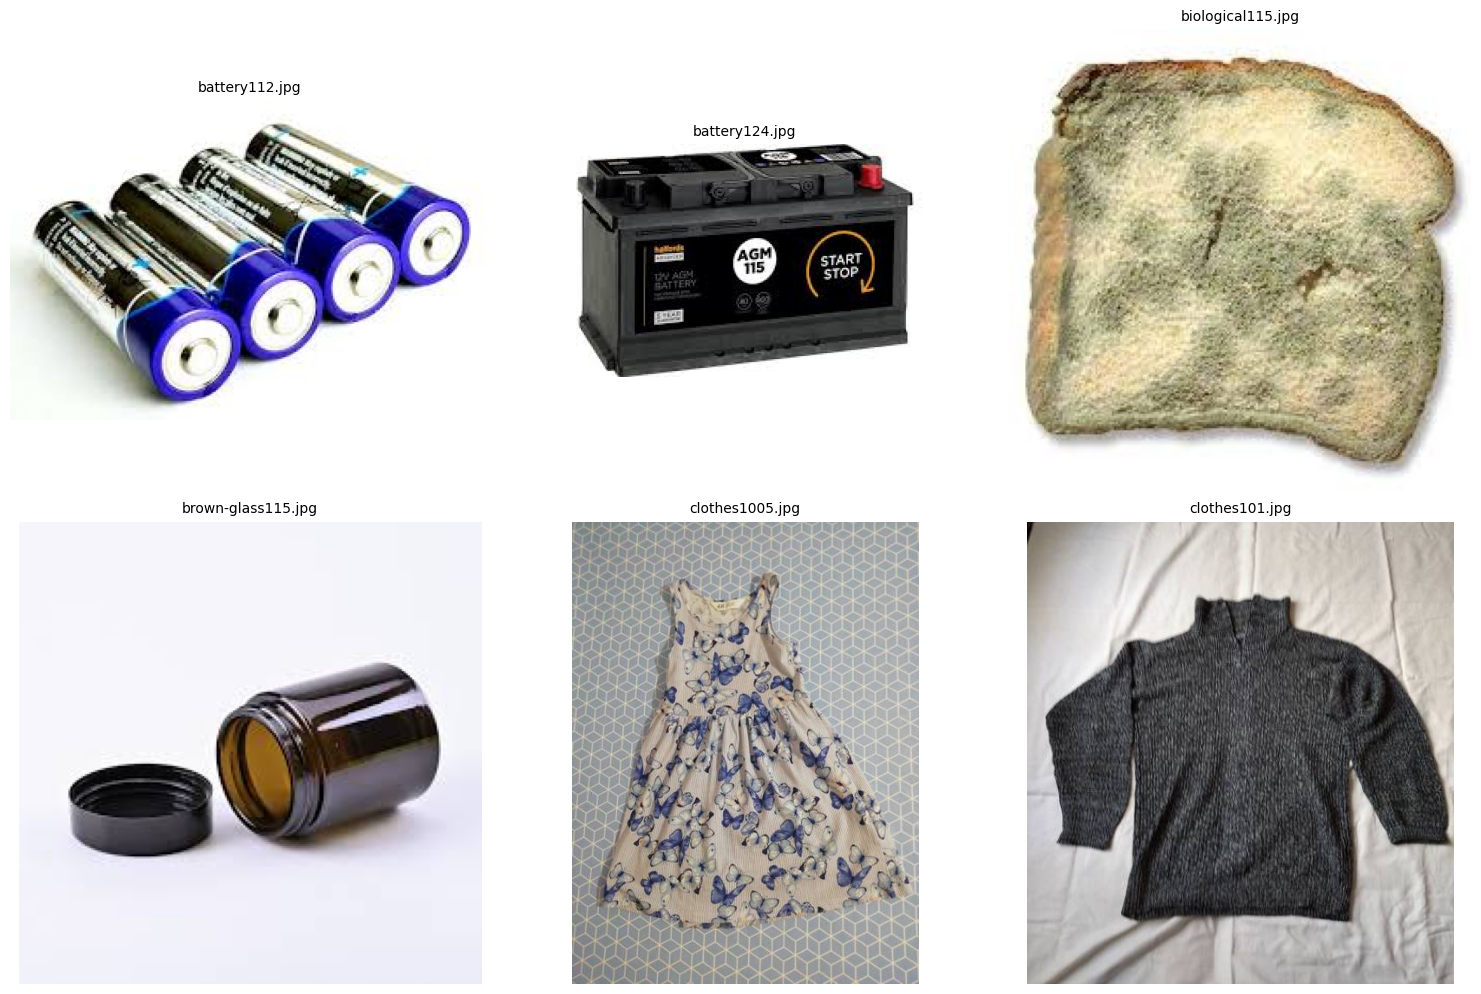



Classifying all 10 images using best CNN model (LargeNet)...
Classes: ['battery', 'biological', 'cardboard', 'glass', 'metal', 'paper', 'plastic']

1. battery112.jpg                 -> battery    (confidence: 0.9561)
2. battery124.jpg                 -> battery    (confidence: 0.8316)
3. biological115.jpg              -> cardboard  (confidence: 0.3559)
4. brown-glass115.jpg             -> glass      (confidence: 0.5780)
5. clothes1005.jpg                -> paper      (confidence: 0.2676)
6. clothes101.jpg                 -> glass      (confidence: 0.5561)
7. metal115.jpg                   -> biological (confidence: 0.2810)
8. metal12.jpg                    -> metal      (confidence: 0.7625)
9. plastic110.jpg                 -> metal      (confidence: 0.4113)
10. plastic115.jpg                 -> biological (confidence: 0.6095)

Predictions saved to 'labels_bonus_cii.csv'

Summary:
                Image Predicted_Class Confidence
0      battery112.jpg         battery     0.9561
1     

In [87]:
# Task 2: Classify 10 images from Part C folder using best CNN model

import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# Path to Part C folder
part_c_folder = '/content/Part C'

# Check if folder exists
if not os.path.exists(part_c_folder):
    print(f"Error: Folder '{part_c_folder}' not found!")
else:
    # Load the best CNN model (large_net)
    large_net.eval()

    # Get all image files from Part C folder
    image_files_c = sorted([f for f in os.listdir(part_c_folder)
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    print(f"Found {len(image_files_c)} images in '{part_c_folder}'")
    print(f"Using device: {device}")

    # Display first few images
    num_display = min(6, len(image_files_c))  # Display up to 6 images
    print(f"\nDisplaying first {num_display} images from Part C folder:")
    print("="*80)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(num_display):
        image_path_c = os.path.join(part_c_folder, image_files_c[i])
        img_display = Image.open(image_path_c).convert('RGB')

        axes[i].imshow(img_display)
        axes[i].set_title(f"{image_files_c[i]}", fontsize=10)
        axes[i].axis('off')

    # Hide any unused subplots
    for i in range(num_display, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print(f"\nClassifying all {len(image_files_c)} images using best CNN model (LargeNet)...")
    print(f"Classes: {classes}")
    print("\n" + "="*80)

    # Store predictions
    predictions_part_c = []

    # Process each image
    for idx, image_file in enumerate(image_files_c, 1):
        image_path_c = os.path.join(part_c_folder, image_file)

        # Load and preprocess image
        img_c = Image.open(image_path_c).convert('RGB')

        # Apply the same transform used during training
        img_tensor_c = transform(img_c).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            output_c = large_net(img_tensor_c)
            probabilities_c = torch.nn.functional.softmax(output_c, dim=1)
            predicted_idx_c = torch.argmax(probabilities_c, dim=1).item()
            confidence = probabilities_c[0, predicted_idx_c].item()

        predicted_class_c = classes[predicted_idx_c]

        # Store prediction
        predictions_part_c.append({
            'Image': image_file,
            'Predicted_Class': predicted_class_c,
            'Confidence': f"{confidence:.4f}"
        })

        # Print result
        print(f"{idx}. {image_file:30s} -> {predicted_class_c:10s} (confidence: {confidence:.4f})")

    print("="*80)

    # Create DataFrame and save to CSV
    df_part_c = pd.DataFrame(predictions_part_c)
    csv_filename_c = 'labels_bonus_cii.csv'
    df_part_c.to_csv(csv_filename_c, index=False)

    print(f"\nPredictions saved to '{csv_filename_c}'")
    print(f"\nSummary:")
    print(df_part_c)

    # Show class distribution
    print("\nClass Distribution:")
    class_counts = df_part_c['Predicted_Class'].value_counts()
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count}")


In [ ]:
# Task 3: Deploy your best model onto huggingface spaces (or other web hosting services) to classify images into the different garbage classes.

# Link to deployed hugging face model
https://huggingface.co/spaces/TarunJoseph101/MIE1517_A1_garbage-classifier

or

https://tarunjoseph101-mie1517-a1-garbage-classifier.hf.space/?logs=build&__theme=system&deep_link=F7AtfIyxAh0


## **Task 3:** Deploy your best model onto huggingface spaces (or other web hosting services) to classify images into the different garbage classes.

### Link to my deployed hugging face model
https://huggingface.co/spaces/TarunJoseph101/MIE1517_A1_garbage-classifier

or

https://tarunjoseph101-mie1517-a1-garbage-classifier.hf.space/?logs=build&__theme=system&deep_link=F7AtfIyxAh0


In [86]:
'''
PROVIDE YOUR ANSWER BELOW

In Task 1, I create and train a new 3-class classifier CNN model to classify images into the 3 classes: "paper", "cardboard", and "other".

In Task 2, I use the my best CNN model (LargeNet) to classify 10 random images which I obtained from the Kaggle dataset for this assignment.

In Task 3, I deploy my best model onto huggingface spaces (powered by Gradio) to classify new unseen images into one of the 7 different garbage classes that it was trained on.



'''

'\nPROVIDE YOUR ANSWER BELOW\n\n\n\n\n\n\n'

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
%%shell
jupyter nbconvert --to html A1.ipynb

(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus

# Assignment Grading Rubric
The grading of the assignment will be based on the following categories:

(1) **10 Pt - EXPLORATORY QUESTIONS** These are basic questions that in most cases can be answered without requiring a fully working and trained neural network model. For example, data loading, processing and visualization, summary statistics, data exploration, model and training setup, etc.

(2) **10 Pt - MODEL** Student has successfully implemented all the required neural network models and has demonstrated successful training of the model without any errors.

(3) **10 Pt - RESULT** Students are evaluated based on the results achieved in comparison to the expected results of the assignment.

(4) **10 Pt - DISCUSSION QUESTIONS** Student demonstrated understanding beyond the basic exploratory questions, can answer some of the more challenging questions, and provide arguments for their model selection decisions.

(5) **10 Pt - COMMUNICATION** Student has provided a quality submission that is easy to read without too many unnecessary output statements that distract the reading of the document. The code has been well commented and all the answers are communicated clearly and concisely.

(6) **5 Pt - BONUS** Student has completed the assignment and has taken on the challenging bonus tasks listed in PART C. The student has demonstrated a good understanding of all aspects of the assignment and has exceeded expectations for the assignment.



**TOTAL GRADE = _____ of 50 Pts**